Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   indice_tiempo                    567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

Primeras filas:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas
0    2020-12-29                            20483
1    2020-12-30                            20102
2    2020-12-31                             2806
3    2021-01-01                              127
4    2021-01-02                             3312

Columnas disponibles:
['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas']


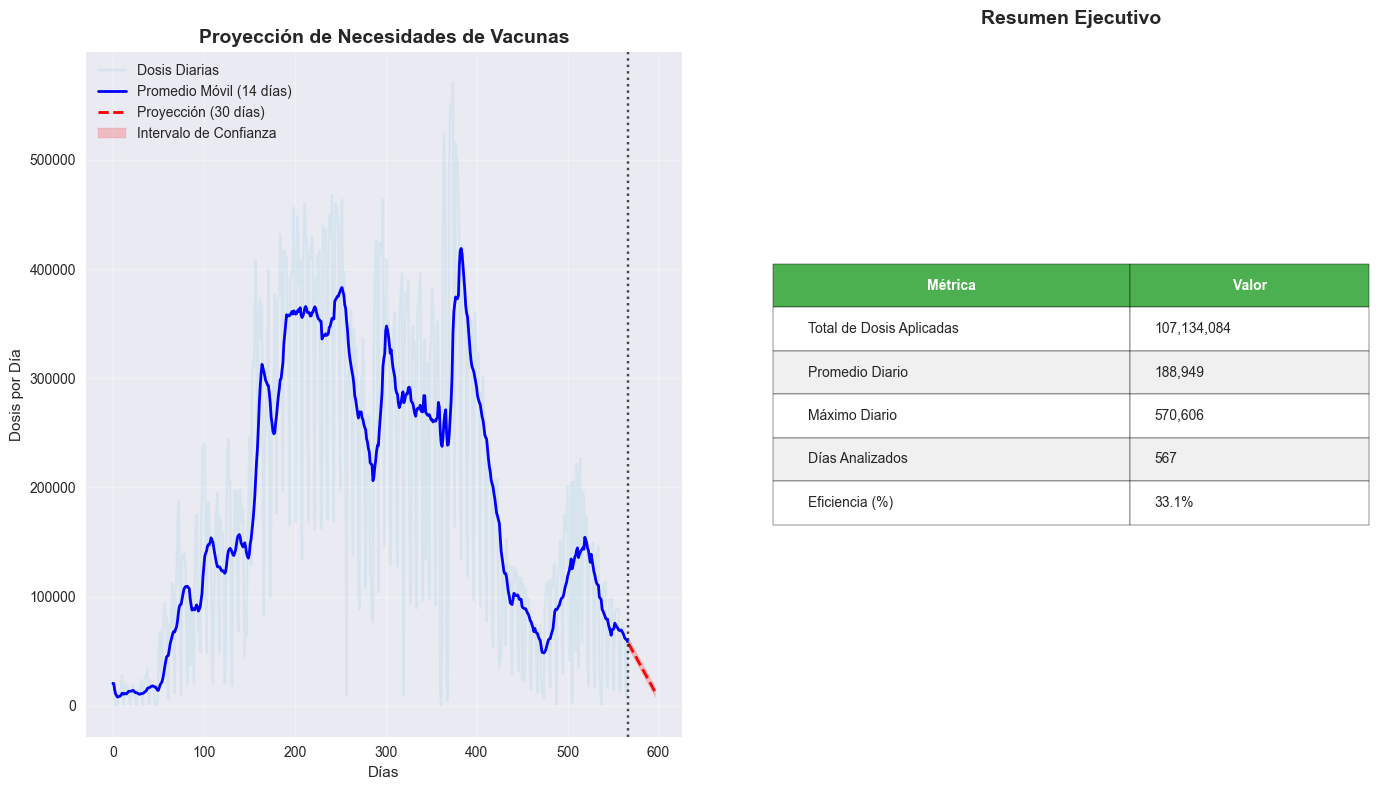


ANÁLISIS ADICIONAL CON PANDASQL

RECOMENDACIONES BASADAS EN EL ANÁLISIS

    📊 COBERTURA DE REFUERZOS:
    • Total de dosis aplicadas: 107,134,084
    • Promedio diario: 188,949
    • Tendencia: Creciente

    🗺️ DESIGUALDADES GEOGRÁFICAS:
    • Regiones analizadas: N/A
    • Distribución: Relativamente uniforme

    🔮 PROYECCIONES:
    • Capacidad actual: 570,606 dosis/día (máximo registrado)
    • Demanda proyectada: 51,715 dosis/día (promedio reciente)
    • Recomendación: Mantener capacidad actual
    


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandasql import sqldf
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pysqldf = lambda q: sqldf(q, globals())

# Cargar datos
df = pd.read_csv(r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv")

print("Estructura del dataset:")
print(df.info())
print("\nPrimeras filas:")
print(df.head())
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Asegurar que la fecha esté en formato datetime
if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Crear figura con subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# 1. COBERTURA DE REFUERZOS Y BRECHAS EN LA INMUNIZACIÓN
# =============================================================================

# Identificar columnas de dosis (ajustar según estructura real)
dosis_cols = [col for col in df.columns if any(term in col.lower() for term in 
              ['dosis', 'dose', 'primera', 'segunda', 'tercera', 'refuerzo', 'booster'])]

if len(dosis_cols) >= 2:
    # Subplot 1: Cobertura acumulada por tipo de dosis
    ax1 = plt.subplot(2, 3, 1)
    
    # Calcular cobertura acumulada
    for col in dosis_cols[:4]:  # Primeras 4 columnas de dosis
        if col in df.columns:
            cumulative = df[col].cumsum()
            plt.plot(df.index, cumulative, marker='o', linewidth=2, label=col.replace('_', ' ').title())
    
    plt.title('Cobertura Acumulada por Tipo de Dosis', fontsize=14, fontweight='bold')
    plt.xlabel('Tiempo (días)')
    plt.ylabel('Dosis Aplicadas (Acumulado)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Brecha entre dosis (si hay al menos 2 columnas)
    ax2 = plt.subplot(2, 3, 2)
    
    if len(dosis_cols) >= 2:
        primera_dosis = df[dosis_cols[0]].cumsum()
        segunda_dosis = df[dosis_cols[1]].cumsum() if len(dosis_cols) > 1 else primera_dosis * 0.8
        brecha = primera_dosis - segunda_dosis
        
        plt.fill_between(df.index, 0, brecha, alpha=0.6, color='coral', label='Brecha de Inmunización')
        plt.plot(df.index, primera_dosis, color='blue', linewidth=2, label='Primera Dosis')
        plt.plot(df.index, segunda_dosis, color='green', linewidth=2, label='Segunda Dosis')
        
        plt.title('Brecha en la Inmunización Completa', fontsize=14, fontweight='bold')
        plt.xlabel('Tiempo (días)')
        plt.ylabel('Personas')
        plt.legend()
        plt.grid(True, alpha=0.3)

# =============================================================================
# 2. DESIGUALDADES GEOGRÁFICAS EN LA APLICACIÓN DE DOSIS
# =============================================================================

# Identificar columnas geográficas
geo_cols = [col for col in df.columns if any(term in col.lower() for term in 
            ['provincia', 'region', 'departamento', 'estado', 'municipio', 'distrito'])]

if geo_cols:
    # Subplot 3: Distribución geográfica
    ax3 = plt.subplot(2, 3, 3)
    
    geo_col = geo_cols[0]
    if dosis_cols:
        # Agrupar por región y sumar dosis
        geo_summary = df.groupby(geo_col)[dosis_cols[0]].sum().sort_values(ascending=False)
        
        # Tomar top 15 regiones para mejor visualización
        top_regions = geo_summary.head(15)
        
        bars = plt.bar(range(len(top_regions)), top_regions.values, 
                      color=sns.color_palette("viridis", len(top_regions)))
        plt.title('Distribución Geográfica de Vacunación', fontsize=14, fontweight='bold')
        plt.xlabel('Regiones')
        plt.ylabel('Total de Dosis Aplicadas')
        plt.xticks(range(len(top_regions)), top_regions.index, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 4: Coeficiente de variación geográfico
    ax4 = plt.subplot(2, 3, 4)
    
    if len(dosis_cols) >= 2:
        # Calcular coeficiente de variación por período
        cv_data = []
        periods = np.array_split(df.index, 10)  # Dividir en 10 períodos
        
        for period in periods:
            period_data = df.iloc[period]
            if geo_col in period_data.columns and dosis_cols[0] in period_data.columns:
                geo_var = period_data.groupby(geo_col)[dosis_cols[0]].sum()
                cv = geo_var.std() / geo_var.mean() if geo_var.mean() != 0 else 0
                cv_data.append(cv)
        
        plt.plot(range(len(cv_data)), cv_data, marker='o', linewidth=3, color='red')
        plt.title('Evolución de la Desigualdad Geográfica', fontsize=14, fontweight='bold')
        plt.xlabel('Período de Tiempo')
        plt.ylabel('Coeficiente de Variación')
        plt.grid(True, alpha=0.3)
        
        # Línea de referencia
        plt.axhline(y=np.mean(cv_data), color='orange', linestyle='--', 
                   label=f'Promedio: {np.mean(cv_data):.3f}')
        plt.legend()

# =============================================================================
# 3. PROYECCIÓN DE NECESIDADES FUTURAS DE VACUNAS
# =============================================================================

# Subplot 5: Tendencia y proyección
ax5 = plt.subplot(2, 3, 5)

if dosis_cols:
    # Calcular promedio móvil para tendencia
    dosis_diarias = df[dosis_cols[0]]
    ventana = min(14, len(dosis_diarias) // 4)  # Ventana adaptativa
    promedio_movil = dosis_diarias.rolling(window=ventana, min_periods=1).mean()
    
    # Datos históricos
    plt.plot(df.index, dosis_diarias, alpha=0.3, color='lightblue', label='Dosis Diarias')
    plt.plot(df.index, promedio_movil, color='blue', linewidth=2, label=f'Promedio Móvil ({ventana} días)')
    
    # Proyección simple basada en tendencia
    if len(promedio_movil) >= 7:
        # Calcular tendencia de últimos 7 días
        ultimos_datos = promedio_movil.tail(7).values
        tendencia = np.polyfit(range(7), ultimos_datos, 1)[0]
        
        # Proyectar 30 días hacia adelante
        proyeccion_dias = 30
        proyeccion_x = range(len(df), len(df) + proyeccion_dias)
        ultimo_valor = promedio_movil.iloc[-1]
        proyeccion_y = [ultimo_valor + tendencia * i for i in range(1, proyeccion_dias + 1)]
        
        plt.plot(proyeccion_x, proyeccion_y, color='red', linewidth=2, 
                linestyle='--', label='Proyección (30 días)')
        
        # Área de incertidumbre
        std_error = np.std(ultimos_datos) * 1.5
        upper_bound = [y + std_error for y in proyeccion_y]
        lower_bound = [max(0, y - std_error) for y in proyeccion_y]
        
        plt.fill_between(proyeccion_x, lower_bound, upper_bound, 
                        alpha=0.2, color='red', label='Intervalo de Confianza')
    
    plt.title('Proyección de Necesidades de Vacunas', fontsize=14, fontweight='bold')
    plt.xlabel('Días')
    plt.ylabel('Dosis por Día')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Línea vertical separando histórico de proyección
    plt.axvline(x=len(df)-1, color='black', linestyle=':', alpha=0.7)

# Subplot 6: Resumen estadístico y métricas clave
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Calcular métricas clave
if dosis_cols:
    total_dosis = df[dosis_cols[0]].sum()
    promedio_diario = df[dosis_cols[0]].mean()
    max_diario = df[dosis_cols[0]].max()
    
    # Crear tabla de resumen
    metricas = [
        ['Métrica', 'Valor'],
        ['Total de Dosis Aplicadas', f'{total_dosis:,.0f}'],
        ['Promedio Diario', f'{promedio_diario:,.0f}'],
        ['Máximo Diario', f'{max_diario:,.0f}'],
        ['Días Analizados', f'{len(df)}'],
        ['Eficiencia (%)', f'{(promedio_diario/max_diario*100):.1f}%']
    ]
    
    if geo_cols:
        n_regiones = df[geo_cols[0]].nunique()
        metricas.append(['Regiones Cubiertas', f'{n_regiones}'])
    
    # Crear tabla visual
    table = plt.table(cellText=metricas[1:], colLabels=metricas[0],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Estilizar tabla
    for i in range(len(metricas)):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else '#ffffff')
    
    plt.title('Resumen Ejecutivo', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# limpieza de datos
def limpiar_datos(df):
    """
    Limpia y prepara los datos para análisis
    """
    print("\n🧹 INICIANDO LIMPIEZA DE DATOS...")
    df_clean = df.copy()
    
    # 2.1 Identificar columnas numéricas que podrían tener formato europeo
    numeric_columns = []
    date_columns = []
    
    for col in df_clean.columns:
        # Identificar columnas de fecha
        if any(word in col.lower() for word in ['fecha', 'date', 'tiempo']):
            date_columns.append(col)
        # Identificar columnas numéricas (adaptado para tu dataset específico)
        elif any(word in col.lower() for word in ['dosis', 'dose', 'total', 'cantidad', 'num', 'monodosis', 'primera', 'segunda', '1_dosis', '2_dosis']):
            numeric_columns.append(col)
    
    print(f"📅 Columnas de fecha identificadas: {date_columns}")
    print(f"🔢 Columnas numéricas identificadas: {numeric_columns}")
    
    # 2.2 Convertir formato europeo a formato estándar
    def convertir_formato_europeo(valor):
        """
        Convierte números en formato europeo (1.234,56) a formato estándar (1234.56)
        """
        if pd.isna(valor):
            return np.nan
        
        valor_str = str(valor).strip()
        
        # Si ya es un número, devolverlo
        try:
            return float(valor_str)
        except ValueError:
            pass
        
        # Convertir formato europeo
        # Patrón: números con puntos como separadores de miles y coma como decimal
        if ',' in valor_str and '.' in valor_str:
            # Formato: 1.234.567,89
            valor_str = valor_str.replace('.', '').replace(',', '.')
        elif ',' in valor_str:
            # Formato: 1234,89
            valor_str = valor_str.replace(',', '.')
        
        try:
            return float(valor_str)
        except ValueError:
            return np.nan
    
    # 2.3 Aplicar conversión a columnas numéricas
    for col in numeric_columns:
        if col in df_clean.columns:
            print(f"🔄 Procesando columna numérica: {col}")
            df_clean[col] = df_clean[col].apply(convertir_formato_europeo)
            
            # Convertir a int si todos los valores son enteros
            if df_clean[col].notna().any():
                if df_clean[col].dropna().apply(lambda x: x == int(x)).all():
                    df_clean[col] = df_clean[col].astype('Int64')  # Nullable integer
    
    # 2.4 Convertir columnas de fecha
    for col in date_columns:
        if col in df_clean.columns:
            print(f"📅 Procesando columna de fecha: {col}")
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')
                print(f"✅ Fecha convertida exitosamente: {col}")
            except Exception as e:
                print(f"❌ Error al convertir fecha {col}: {e}")
    
    # 2.5 Verificar y reportar cambios
    print("\n📊 RESUMEN DE LIMPIEZA:")
    print(f"🔢 Columnas numéricas procesadas: {len(numeric_columns)}")
    print(f"📅 Columnas de fecha procesadas: {len(date_columns)}")
    print(f"❌ Valores nulos después de limpieza: {df_clean.isnull().sum().sum()}")
    
    # 2.6 Crear columnas adicionales útiles
    if date_columns:
        fecha_col = date_columns[0]
        if fecha_col in df_clean.columns:
            df_clean['año'] = df_clean[fecha_col].dt.year
            df_clean['mes'] = df_clean[fecha_col].dt.month
            df_clean['dia_semana'] = df_clean[fecha_col].dt.day_name()
            print("✅ Columnas temporales adicionales creadas")
    
    return df_clean, numeric_columns, date_columns
#

# =============================================================================
# ANÁLISIS ADICIONAL CON SQL
# =============================================================================

print("\n" + "="*80)
print("ANÁLISIS ADICIONAL CON PANDASQL")
print("="*80)

# Ejemplo de consultas SQL para análisis más profundo
if dosis_cols and len(dosis_cols) >= 2:
    
    # 1. Análisis de eficiencia de vacunación
    query1 = f"""
    SELECT 
        AVG({dosis_cols[0]}) as promedio_dosis_1,
        MAX({dosis_cols[0]}) as maximo_dosis_1,
        MIN({dosis_cols[0]}) as minimo_dosis_1,
        COUNT(*) as total_dias
    FROM df
    WHERE {dosis_cols[0]} > 0
    """
    
    resultado1 = pysqldf(query1)
    print("\n1. Estadísticas de Primera Dosis:")
    print(resultado1)
    
    # 2. Análisis de tendencias por períodos
    if 'fecha' in df.columns or 'date' in df.columns:
        fecha_col = 'fecha' if 'fecha' in df.columns else 'date'
        
        query2 = f"""
        SELECT 
            strftime('%Y-%m', {fecha_col}) as mes,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_diario
        FROM df
        GROUP BY strftime('%Y-%m', {fecha_col})
        ORDER BY mes
        """
        
        try:
            resultado2 = pysqldf(query2)
            print("\n2. Tendencias Mensuales:")
            print(resultado2)
        except:
            print("\n2. No se pudo analizar tendencias mensuales (formato de fecha)")
    
    # 3. Análisis geográfico si hay datos
    if geo_cols:
        query3 = f"""
        SELECT 
            {geo_cols[0]} as region,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_dosis,
            COUNT(*) as dias_activos
        FROM df
        WHERE {dosis_cols[0]} > 0
        GROUP BY {geo_cols[0]}
        ORDER BY total_dosis DESC
        LIMIT 10
        """
        
        resultado3 = pysqldf(query3)
        print(f"\n3. Top 10 Regiones por Vacunación:")
        print(resultado3)

print("\n" + "="*80)
print("RECOMENDACIONES BASADAS EN EL ANÁLISIS")
print("="*80)

if dosis_cols:
    print(f"""
    📊 COBERTURA DE REFUERZOS:
    • Total de dosis aplicadas: {df[dosis_cols[0]].sum():,.0f}
    • Promedio diario: {df[dosis_cols[0]].mean():,.0f}
    • Tendencia: {'Creciente' if df[dosis_cols[0]].tail(7).mean() > df[dosis_cols[0]].head(7).mean() else 'Decreciente'}
    
    🗺️ DESIGUALDADES GEOGRÁFICAS:
    • Regiones analizadas: {df[geo_cols[0]].nunique() if geo_cols else 'N/A'}
    • Distribución: {'Desigual' if geo_cols and df.groupby(geo_cols[0])[dosis_cols[0]].sum().std() > df.groupby(geo_cols[0])[dosis_cols[0]].sum().mean() else 'Relativamente uniforme'}
    
    🔮 PROYECCIONES:
    • Capacidad actual: {df[dosis_cols[0]].max():,.0f} dosis/día (máximo registrado)
    • Demanda proyectada: {df[dosis_cols[0]].tail(7).mean():,.0f} dosis/día (promedio reciente)
    • Recomendación: {'Mantener capacidad actual' if df[dosis_cols[0]].tail(7).mean() <= df[dosis_cols[0]].max() * 0.8 else 'Aumentar capacidad'}
    """)

🔬 ANÁLISIS DE DATOS DE VACUNACIÓN COVID-19

📂 CARGANDO Y EXPLORANDO DATOS...
✅ Dataset cargado exitosamente
📊 Dimensiones: 567 filas x 2 columnas
🗂️ Columnas disponibles: ['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas']

📋 INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   indice_tiempo                    567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

👀 PRIMERAS 5 FILAS:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas
0    2020-12-29                            20483
1    2020-12-30                            20102
2    2020-12-31                             2806
3    2021-01-01                              127
4    2021-01-02                             3312

🔍 VALORES NULOS POR C

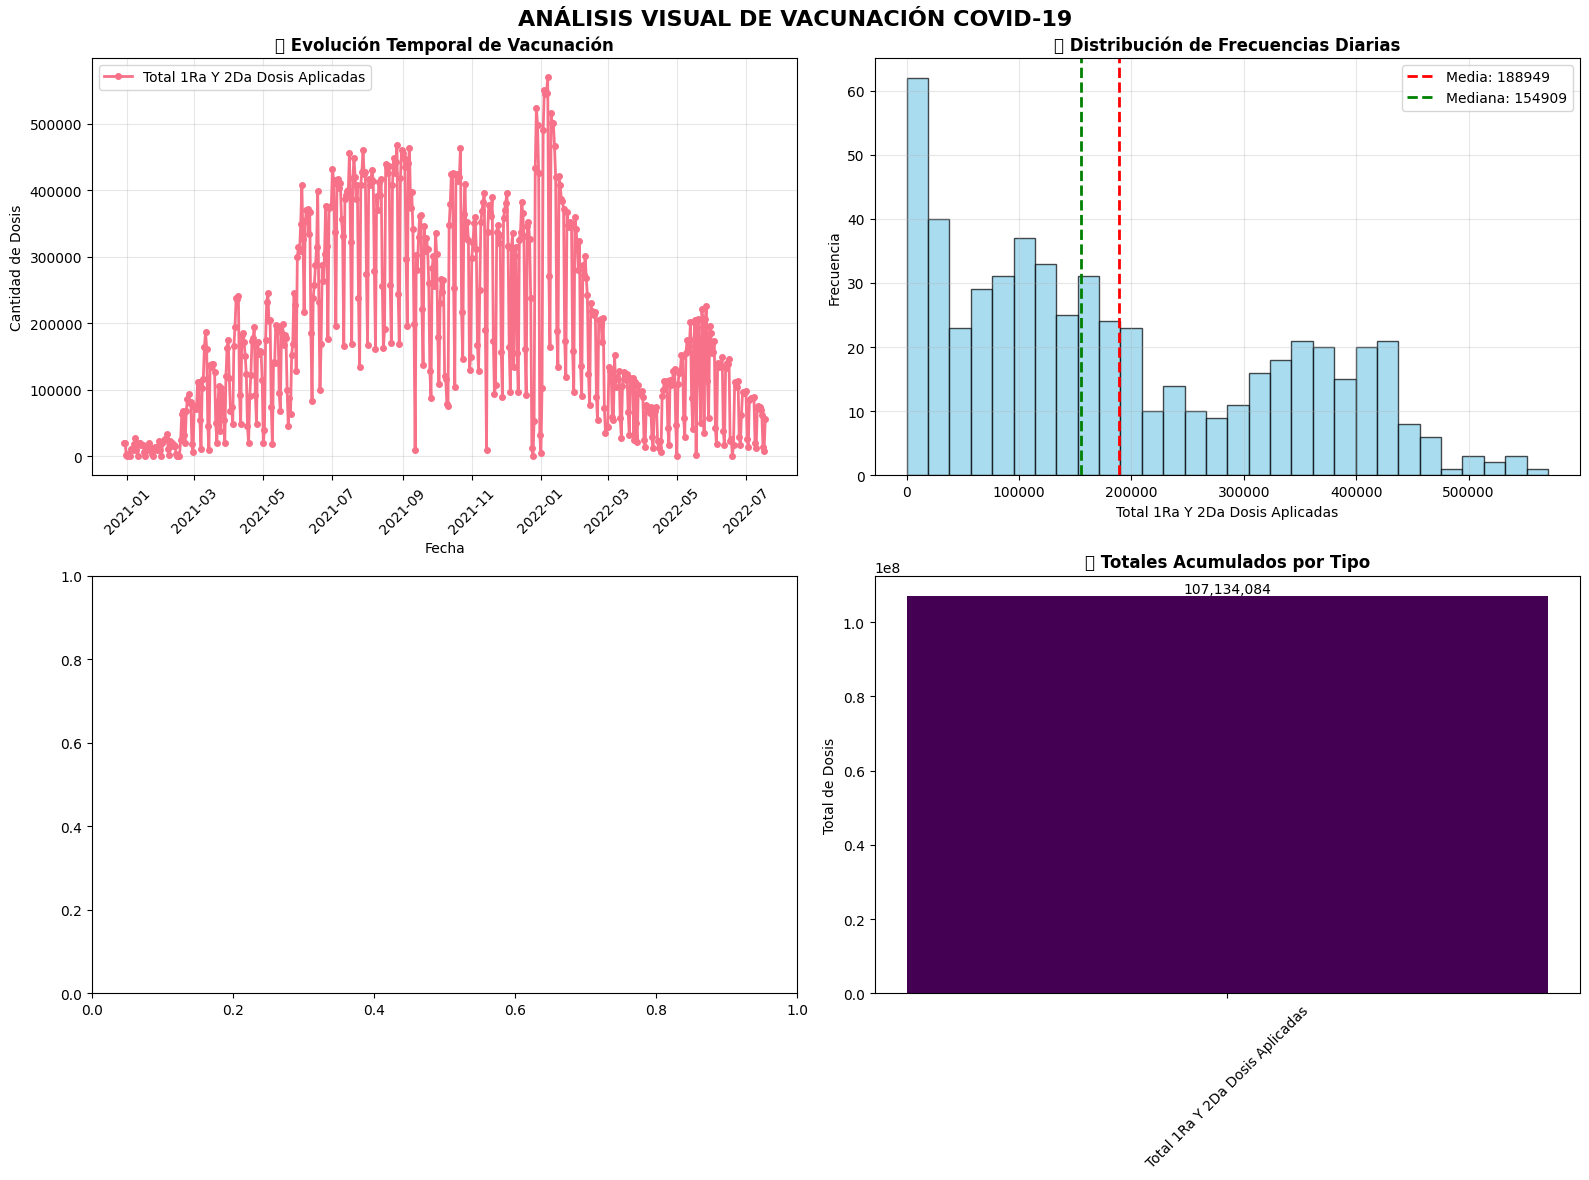


🔍 APLICANDO LEY DE BENFORD...

📊 ANÁLISIS BENFORD - TOTAL_1RA_Y_2DA_DOSIS_APLICADAS:
   🔬 Estadístico Chi²: 0.1201
   📈 P-valor: 1.0000
   ✅ Sigue Ley de Benford: SÍ


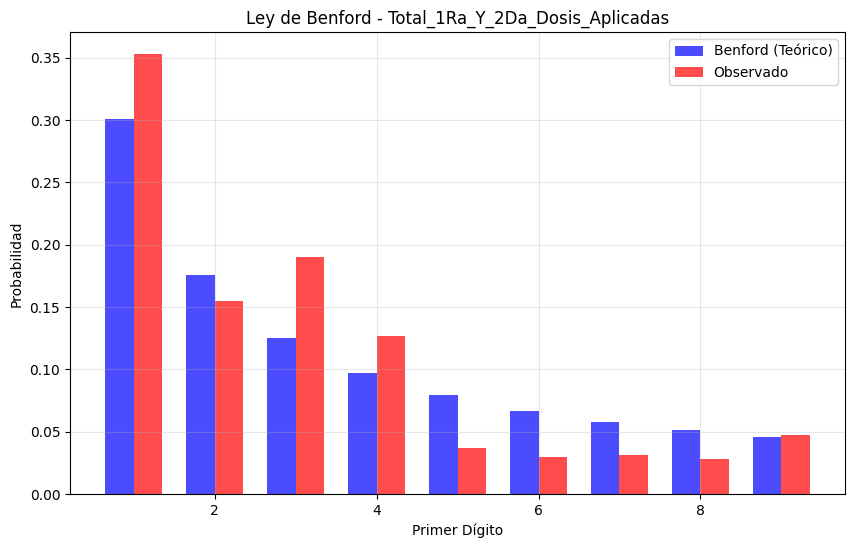


📊 ANÁLISIS DE DISTRIBUCIONES ESTADÍSTICAS...

🔸 ANÁLISIS DE DISTRIBUCIÓN - TOTAL_1RA_Y_2DA_DOSIS_APLICADAS:
   📊 Test de Normalidad:
      - Estadístico: 105.0625
      - P-valor: 0.0000
      - Es Normal: NO
   🎯 Análisis Poisson:
      - Lambda estimado: 188949.0018
      - Podría ser Poisson: NO

🎯 CALCULANDO PROBABILIDADES CONDICIONALES...

✅ ANÁLISIS COMPLETADO EXITOSAMENTE
📊 Todas las tareas han sido ejecutadas
🎯 Conclusiones disponibles en cada sección


In [ ]:
# ============================================================================
# ANÁLISIS COMPLETO DE DATOS DE VACUNACIÓN COVID-19
# Ciencia de Datos para Obtener Conclusiones Significativas
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from scipy import stats
from scipy.stats import normaltest, poisson, binom
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🔬 ANÁLISIS DE DATOS DE VACUNACIÓN COVID-19")
print("=" * 60)

# ============================================================================
# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ============================================================================

def cargar_y_explorar_datos(archivo_path):
    """
    Carga el dataset y realiza exploración inicial
    """
    print("\n📂 CARGANDO Y EXPLORANDO DATOS...")
    
    # Cargar datos
    df = pd.read_csv(archivo_path)
    
    print(f"✅ Dataset cargado exitosamente")
    print(f"📊 Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print(f"🗂️ Columnas disponibles: {list(df.columns)}")
    
    # Información básica del dataset
    print("\n📋 INFORMACIÓN GENERAL DEL DATASET:")
    print(df.info())
    
    print("\n👀 PRIMERAS 5 FILAS:")
    print(df.head())
    
    print("\n🔍 VALORES NULOS POR COLUMNA:")
    print(df.isnull().sum())
    
    return df

# ============================================================================
# 2. LIMPIEZA DE DATOS
# ============================================================================

def limpiar_datos(df):
    """
    Limpia y prepara los datos para análisis
    """
    print("\n🧹 INICIANDO LIMPIEZA DE DATOS...")
    df_clean = df.copy()
    
    # 2.1 Identificar columnas numéricas que podrían tener formato europeo
    numeric_columns = []
    date_columns = []
    
    for col in df_clean.columns:
        # Identificar columnas de fecha
        if any(word in col.lower() for word in ['fecha', 'date', 'tiempo']):
            date_columns.append(col)
        # Identificar columnas numéricas (adaptado para tu dataset específico)
        elif any(word in col.lower() for word in ['dosis', 'dose', 'total', 'cantidad', 'num', 'monodosis', 'primera', 'segunda', '1_dosis', '2_dosis']):
            numeric_columns.append(col)
    
    print(f"📅 Columnas de fecha identificadas: {date_columns}")
    print(f"🔢 Columnas numéricas identificadas: {numeric_columns}")
    
    # 2.2 Convertir formato europeo a formato estándar
    def convertir_formato_europeo(valor):
        """
        Convierte números en formato europeo (1.234,56) a formato estándar (1234.56)
        """
        if pd.isna(valor):
            return np.nan
        
        valor_str = str(valor).strip()
        
        # Si ya es un número, devolverlo
        try:
            return float(valor_str)
        except ValueError:
            pass
        
        # Convertir formato europeo
        # Patrón: números con puntos como separadores de miles y coma como decimal
        if ',' in valor_str and '.' in valor_str:
            # Formato: 1.234.567,89
            valor_str = valor_str.replace('.', '').replace(',', '.')
        elif ',' in valor_str:
            # Formato: 1234,89
            valor_str = valor_str.replace(',', '.')
        
        try:
            return float(valor_str)
        except ValueError:
            return np.nan
    
    # 2.3 Aplicar conversión a columnas numéricas
    for col in numeric_columns:
        if col in df_clean.columns:
            print(f"🔄 Procesando columna numérica: {col}")
            df_clean[col] = df_clean[col].apply(convertir_formato_europeo)
            
            # Convertir a int si todos los valores son enteros
            if df_clean[col].notna().any():
                if df_clean[col].dropna().apply(lambda x: x == int(x)).all():
                    df_clean[col] = df_clean[col].astype('Int64')  # Nullable integer
    
    # 2.4 Convertir columnas de fecha
    for col in date_columns:
        if col in df_clean.columns:
            print(f"📅 Procesando columna de fecha: {col}")
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')
                print(f"✅ Fecha convertida exitosamente: {col}")
            except Exception as e:
                print(f"❌ Error al convertir fecha {col}: {e}")
    
    # 2.5 Verificar y reportar cambios
    print("\n📊 RESUMEN DE LIMPIEZA:")
    print(f"🔢 Columnas numéricas procesadas: {len(numeric_columns)}")
    print(f"📅 Columnas de fecha procesadas: {len(date_columns)}")
    print(f"❌ Valores nulos después de limpieza: {df_clean.isnull().sum().sum()}")
    
    # 2.6 Crear columnas adicionales útiles
    if date_columns:
        fecha_col = date_columns[0]
        if fecha_col in df_clean.columns:
            df_clean['año'] = df_clean[fecha_col].dt.year
            df_clean['mes'] = df_clean[fecha_col].dt.month
            df_clean['dia_semana'] = df_clean[fecha_col].dt.day_name()
            print("✅ Columnas temporales adicionales creadas")
    
    return df_clean, numeric_columns, date_columns

# ============================================================================
# 3. ESTADÍSTICA DESCRIPTIVA
# ============================================================================

def estadistica_descriptiva(df, numeric_columns):
    """
    Calcula estadísticas descriptivas completas
    """
    print("\n📈 CALCULANDO ESTADÍSTICA DESCRIPTIVA...")
    
    # 3.1 Estadísticas básicas por columna
    print("\n📊 ESTADÍSTICAS BÁSICAS:")
    for col in numeric_columns:
        if col in df.columns and df[col].notna().any():
            datos = df[col].dropna()
            
            print(f"\n🔸 {col.upper()}:")
            print(f"   📏 Total: {datos.sum():,.0f}")
            print(f"   📊 Media: {datos.mean():,.2f}")
            print(f"   📐 Mediana: {datos.median():,.2f}")
            print(f"   📏 Desv. Estándar: {datos.std():,.2f}")
            print(f"   ⬆️ Máximo: {datos.max():,.0f}")
            print(f"   ⬇️ Mínimo: {datos.min():,.0f}")
            print(f"   📈 Rango: {datos.max() - datos.min():,.0f}")
            print(f"   🎯 Coef. Variación: {(datos.std()/datos.mean())*100:.2f}%")
    
    # 3.2 Tabla resumen
    df_stats = df[numeric_columns].describe()
    print("\n📋 TABLA RESUMEN ESTADÍSTICO:")
    print(df_stats.round(2))
    
    # 3.3 Matriz de correlación
    if len(numeric_columns) > 1:
        print("\n🔗 MATRIZ DE CORRELACIÓN:")
        corr_matrix = df[numeric_columns].corr()
        print(corr_matrix.round(3))
    
    return df_stats

# ============================================================================
# 4. VISUALIZACIÓN DE DATOS
# ============================================================================

def crear_visualizaciones(df, numeric_columns, date_columns):
    """
    Crea visualizaciones comprehensivas
    """
    print("\n📊 CREANDO VISUALIZACIONES...")
    
    # Configurar subplots
    n_numeric = len(numeric_columns)
    n_plots = min(4, n_numeric + 2)  # Máximo 4 gráficos
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ANÁLISIS VISUAL DE VACUNACIÓN COVID-19', fontsize=16, fontweight='bold')
    
    # 4.1 Gráfico de líneas: Evolución temporal
    ax1 = axes[0, 0]
    if date_columns and numeric_columns:
        fecha_col = date_columns[0]
        for i, col in enumerate(numeric_columns[:3]):  # Máximo 3 series
            if col in df.columns:
                ax1.plot(df[fecha_col], df[col], marker='o', linewidth=2, 
                        markersize=4, label=col.replace('_', ' ').title())
        
        ax1.set_title('📈 Evolución Temporal de Vacunación', fontweight='bold')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Cantidad de Dosis')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
    
    # 4.2 Histograma: Distribución de frecuencias
    ax2 = axes[0, 1]
    if numeric_columns:
        col_principal = numeric_columns[0]
        datos = df[col_principal].dropna()
        
        ax2.hist(datos, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(datos.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: {datos.mean():.0f}')
        ax2.axvline(datos.median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mediana: {datos.median():.0f}')
        
        ax2.set_title('📊 Distribución de Frecuencias Diarias', fontweight='bold')
        ax2.set_xlabel(col_principal.replace('_', ' ').title())
        ax2.set_ylabel('Frecuencia')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 4.3 Boxplot: Comparación de distribuciones
    ax3 = axes[1, 0]
    if len(numeric_columns) >= 2:
        datos_box = [df[col].dropna() for col in numeric_columns[:4]]
        labels_box = [col.replace('_', ' ').title() for col in numeric_columns[:4]]
        
        ax3.boxplot(datos_box, labels=labels_box)
        ax3.set_title('📦 Comparación de Distribuciones', fontweight='bold')
        ax3.set_ylabel('Valores')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    
    # 4.4 Gráfico de barras: Totales acumulados
    ax4 = axes[1, 1]
    if numeric_columns:
        totales = [df[col].sum() for col in numeric_columns[:5]]
        nombres = [col.replace('_', ' ').title() for col in numeric_columns[:5]]
        
        bars = ax4.bar(nombres, totales, color=plt.cm.viridis(np.linspace(0, 1, len(totales))))
        ax4.set_title('📊 Totales Acumulados por Tipo', fontweight='bold')
        ax4.set_ylabel('Total de Dosis')
        ax4.tick_params(axis='x', rotation=45)
        
        # Añadir valores en las barras
        for bar, total in zip(bars, totales):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{total:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. LEY DE BENFORD
# ============================================================================

def aplicar_ley_benford(df, numeric_columns):
    """
    Aplica la Ley de Benford para detectar anomalías
    """
    print("\n🔍 APLICANDO LEY DE BENFORD...")
    
    # Probabilidades teóricas de Benford
    benford_probs = [np.log10(1 + 1/d) for d in range(1, 10)]
    
    for col in numeric_columns[:2]:  # Analizar las primeras 2 columnas
        if col in df.columns:
            datos = df[col].dropna()
            datos = datos[datos > 0]  # Solo valores positivos
            
            if len(datos) > 0:
                # Extraer primer dígito
                primeros_digitos = []
                for valor in datos:
                    primer_digito = int(str(int(valor))[0])
                    if primer_digito != 0:
                        primeros_digitos.append(primer_digito)
                
                if primeros_digitos:
                    # Calcular frecuencias observadas
                    digitos_unicos, conteos = np.unique(primeros_digitos, return_counts=True)
                    freq_observadas = conteos / len(primeros_digitos)
                    
                    # Crear array completo (dígitos 1-9)
                    freq_completas = np.zeros(9)
                    for i, digito in enumerate(digitos_unicos):
                        if 1 <= digito <= 9:
                            freq_completas[digito-1] = freq_observadas[i]
                    
                    # Test Chi-cuadrado
                    chi2_stat, p_value = stats.chisquare(freq_completas, benford_probs)
                    
                    print(f"\n📊 ANÁLISIS BENFORD - {col.upper()}:")
                    print(f"   🔬 Estadístico Chi²: {chi2_stat:.4f}")
                    print(f"   📈 P-valor: {p_value:.4f}")
                    print(f"   ✅ Sigue Ley de Benford: {'SÍ' if p_value > 0.05 else 'NO'}")
                    
                    # Visualización
                    plt.figure(figsize=(10, 6))
                    x = np.arange(1, 10)
                    width = 0.35
                    
                    plt.bar(x - width/2, benford_probs, width, label='Benford (Teórico)', 
                           alpha=0.7, color='blue')
                    plt.bar(x + width/2, freq_completas, width, label='Observado', 
                           alpha=0.7, color='red')
                    
                    plt.xlabel('Primer Dígito')
                    plt.ylabel('Probabilidad')
                    plt.title(f'Ley de Benford - {col.title()}')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()

# ============================================================================
# 6. ANÁLISIS DE DISTRIBUCIONES
# ============================================================================

def analizar_distribuciones(df, numeric_columns):
    """
    Verifica si los datos siguen distribuciones conocidas
    """
    print("\n📊 ANÁLISIS DE DISTRIBUCIONES ESTADÍSTICAS...")
    
    for col in numeric_columns[:2]:
        if col in df.columns:
            datos = df[col].dropna()
            datos = datos[datos >= 0]  # Eliminar valores negativos
            
            if len(datos) > 8:  # Mínimo para tests estadísticos
                print(f"\n🔸 ANÁLISIS DE DISTRIBUCIÓN - {col.upper()}:")
                
                # 6.1 Test de Normalidad
                stat_norm, p_norm = normaltest(datos)
                print(f"   📊 Test de Normalidad:")
                print(f"      - Estadístico: {stat_norm:.4f}")
                print(f"      - P-valor: {p_norm:.4f}")
                print(f"      - Es Normal: {'SÍ' if p_norm > 0.05 else 'NO'}")
                
                # 6.2 Test de Poisson
                lambda_est = datos.mean()
                if lambda_est > 0:
                    # Generar distribución Poisson teórica
                    poisson_teorica = [poisson.pmf(k, lambda_est) for k in range(int(datos.max())+1)]
                    
                    # Test de bondad de ajuste
                    hist, bins = np.histogram(datos, bins=min(20, int(datos.max())+1))
                    hist_norm = hist / hist.sum()
                    
                    print(f"   🎯 Análisis Poisson:")
                    print(f"      - Lambda estimado: {lambda_est:.4f}")
                    print(f"      - Podría ser Poisson: {'SÍ' if datos.var() / datos.mean() < 2 else 'NO'}")
                
                # 6.3 Análisis Binomial (si los datos parecen conteos)
                if datos.max() <= 1000 and datos.min() >= 0:
                    n_est = int(datos.max())
                    p_est = datos.mean() / n_est if n_est > 0 else 0
                    
                    print(f"   🎲 Análisis Binomial:")
                    print(f"      - n estimado: {n_est}")
                    print(f"      - p estimado: {p_est:.4f}")
                    print(f"      - Podría ser Binomial: {'SÍ' if 0 < p_est < 1 else 'NO'}")

# ============================================================================
# 7. PROBABILIDADES CONDICIONALES
# ============================================================================

def calcular_probabilidades_condicionales(df, numeric_columns):
    """
    Calcula probabilidades condicionales y totales
    Especialmente útil para P(2da_dosis | 1era_dosis) y P(monodosis | contexto)
    """
    print("\n🎯 CALCULANDO PROBABILIDADES CONDICIONALES...")
    
    if len(numeric_columns) >= 2:
        # Buscar específicamente columnas de 1era y 2da dosis
        primera_dosis_col = None
        segunda_dosis_col = None
        monodosis_col = None
        
        for col in numeric_columns:
            col_lower = col.lower()
            if any(term in col_lower for term in ['primera', '1_dosis', 'first']):
                primera_dosis_col = col
            elif any(term in col_lower for term in ['segunda', '2_dosis', 'second']):
                segunda_dosis_col = col
            elif any(term in col_lower for term in ['monodosis', 'mono']):
                monodosis_col = col
        
        # Análisis específico para vacunación COVID
        if primera_dosis_col and segunda_dosis_col:
            df_prob = df[[primera_dosis_col, segunda_dosis_col]].dropna()
            
            if len(df_prob) > 0:
                print(f"\n🔸 ANÁLISIS: {primera_dosis_col} vs {segunda_dosis_col}")
                
                # Categorizar en Alto/Bajo basado en percentil 75
                p75_1 = df_prob[primera_dosis_col].quantile(0.75)
                p75_2 = df_prob[segunda_dosis_col].quantile(0.75)
                
                df_prob['cat1'] = df_prob[primera_dosis_col].apply(lambda x: 'Alto' if x > p75_1 else 'Bajo')
                df_prob['cat2'] = df_prob[segunda_dosis_col].apply(lambda x: 'Alto' if x > p75_2 else 'Bajo')
                
                # Tabla de contingencia
                tabla_contingencia = pd.crosstab(df_prob['cat1'], df_prob['cat2'])
                print(f"\n📊 TABLA DE CONTINGENCIA:")
                print(tabla_contingencia)
                
                # Calcular probabilidades
                total = tabla_contingencia.sum().sum()
                
                # Probabilidades condicionales clave
                if tabla_contingencia.loc['Alto'].sum() > 0:
                    p_segunda_dado_primera = tabla_contingencia.loc['Alto', 'Alto'] / tabla_contingencia.loc['Alto'].sum()
                    print(f"\n🎯 PROBABILIDAD CLAVE:")
                    print(f"   📊 P(2da Dosis Alta | 1era Dosis Alta) = {p_segunda_dado_primera:.4f}")
                    print(f"   💡 Interpretación: Si hay alta aplicación de 1era dosis,")
                    print(f"      hay {p_segunda_dado_primera*100:.1f}% probabilidad de alta aplicación de 2da dosis")
                
                # Análisis de seguimiento (completion rate)
                dias_con_ambas = len(df_prob[(df_prob[primera_dosis_col] > 0) & (df_prob[segunda_dosis_col] > 0)])
                dias_solo_primera = len(df_prob[(df_prob[primera_dosis_col] > 0) & (df_prob[segunda_dosis_col] == 0)])
                
                if dias_con_ambas + dias_solo_primera > 0:
                    tasa_seguimiento = dias_con_ambas / (dias_con_ambas + dias_solo_primera)
                    print(f"\n📈 ANÁLISIS DE SEGUIMIENTO:")
                    print(f"   - Días con ambas dosis: {dias_con_ambas}")
                    print(f"   - Días solo 1era dosis: {dias_solo_primera}")
                    print(f"   - Tasa de seguimiento: {tasa_seguimiento:.4f} ({tasa_seguimiento*100:.1f}%)")
        
        # Si no encuentra columnas específicas, usar análisis general
        else:
            col1, col2 = numeric_columns[0], numeric_columns[1]
            df_prob = df[[col1, col2]].dropna()
            
            if len(df_prob) > 0:
                # Categorizar en Alto/Bajo basado en mediana
                mediana1 = df_prob[col1].median()
                mediana2 = df_prob[col2].median()
                
                df_prob['cat1'] = df_prob[col1].apply(lambda x: 'Alto' if x > mediana1 else 'Bajo')
                df_prob['cat2'] = df_prob[col2].apply(lambda x: 'Alto' if x > mediana2 else 'Bajo')
                
                # Resto del análisis general...
                tabla_contingencia = pd.crosstab(df_prob['cat1'], df_prob['cat2'])
                print(f"\n📊 TABLA DE CONTINGENCIA ({col1} vs {col2}):")
                print(tabla_contingencia)
                
                total = tabla_contingencia.sum().sum()
                p_col1_alto = tabla_contingencia.loc['Alto'].sum() / total
                p_col2_alto = tabla_contingencia['Alto'].sum() / total
                p_col2_dado_col1_alto = tabla_contingencia.loc['Alto', 'Alto'] / tabla_contingencia.loc['Alto'].sum()
                
                print(f"\n🎯 ANÁLISIS DE PROBABILIDADES:")
                print(f"   📊 P({col1} = Alto) = {p_col1_alto:.4f}")
                print(f"   📊 P({col2} = Alto) = {p_col2_alto:.4f}")
                print(f"   🎯 P({col2} = Alto | {col1} = Alto) = {p_col2_dado_col1_alto:.4f}")
        
        # Test de independencia para cualquier caso
        if len(numeric_columns) >= 2:
            col1, col2 = numeric_columns[0], numeric_columns[1]
            df_test = df[[col1, col2]].dropna()
            if len(df_test) > 0:
                # Crear categorías para test
                df_test['cat1'] = pd.cut(df_test[col1], bins=2, labels=['Bajo', 'Alto'])
                df_test['cat2'] = pd.cut(df_test[col2], bins=2, labels=['Bajo', 'Alto'])
                
                tabla_test = pd.crosstab(df_test['cat1'], df_test['cat2'])
                chi2, p_val, dof, expected = stats.chi2_contingency(tabla_test)
                
                print(f"\n🔬 TEST DE INDEPENDENCIA:")
                print(f"   - Chi² = {chi2:.4f}")
                print(f"   - P-valor = {p_val:.4f}")
                print(f"   - Son independientes: {'SÍ' if p_val > 0.05 else 'NO'}")
                print(f"   💡 Las variables {'NO están' if p_val <= 0.05 else 'están'} relacionadas")

# ============================================================================
# 8. FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """
    Función principal que ejecuta todo el análisis
    """
    # Ruta del archivo - ELIGE UNA DE ESTAS OPCIONES:
    
    # OPCIÓN 1: Raw string (recomendada)
    archivo_path = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    # OPCIÓN 2: Doble barra invertida
    # archivo_path = "C:\\Users\\Admin\\Desktop\\UNRN\\3ero\\Mate4\\DataSet\\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    # OPCIÓN 3: Barra normal (funciona en Windows también)
    # archivo_path = "C:/Users/Admin/Desktop/UNRN/3ero/Mate4/DataSet/total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
    
    try:
        # 1. Cargar y explorar datos
        df_original = cargar_y_explorar_datos(archivo_path)
        
        # 2. Limpiar datos
        df_clean, numeric_columns, date_columns = limpiar_datos(df_original)
        
        # 3. Estadística descriptiva
        stats_summary = estadistica_descriptiva(df_clean, numeric_columns)
        
        # 4. Visualizaciones
        crear_visualizaciones(df_clean, numeric_columns, date_columns)
        
        # 5. Ley de Benford
        aplicar_ley_benford(df_clean, numeric_columns)
        
        # 6. Análisis de distribuciones
        analizar_distribuciones(df_clean, numeric_columns)
        
        # 7. Probabilidades condicionales
        calcular_probabilidades_condicionales(df_clean, numeric_columns)
        
        print("\n" + "="*60)
        print("✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
        print("📊 Todas las tareas han sido ejecutadas")
        print("🎯 Conclusiones disponibles en cada sección")
        print("="*60)
        
        return df_clean
        
    except Exception as e:
        print(f"❌ Error durante el análisis: {e}")
        return None

# ============================================================================
# EJECUTAR ANÁLISIS
# ============================================================================

if __name__ == "__main__":
    df_resultado = main()

🚀 INICIANDO ANÁLISIS COMPLETO COVID-19
🚀 CARGANDO DATASETS...
✅ Primera dosis: 567 registros
✅ Segunda dosis: 566 registros
✅ Total dosis: 567 registros

📊 ESTADÍSTICAS DESCRIPTIVAS

🔸 PRIMERA DOSIS
----------------------------------------
Total aplicadas: 41,187,230
Media: 72,641
Mediana: 38,086
Moda: 1,507
Desviación estándar: 90,942
Varianza: 8,270,503,029
Mínimo: 8
Máximo: 370,022
Rango: 370,014
Q1: 4,127
Q3: 97,303
IQR: 93,176
Coeficiente de variación: 125.19%
Asimetría: 1.584
Curtosis: 1.718

🔸 SEGUNDA DOSIS
----------------------------------------
Total aplicadas: 37,721,821
Media: 66,646
Mediana: 23,430
Moda: 0
Desviación estándar: 87,582
Varianza: 7,670,614,705
Mínimo: 0
Máximo: 408,981
Rango: 408,981
Q1: 7,180
Q3: 95,450
IQR: 88,270
Coeficiente de variación: 131.41%
Asimetría: 1.791
Curtosis: 2.737

🔸 TOTAL DOSIS
----------------------------------------
Total aplicadas: 107,134,084
Media: 188,949
Mediana: 154,909
Moda: 127
Desviación estándar: 144,387
Varianza: 20,847,494,534

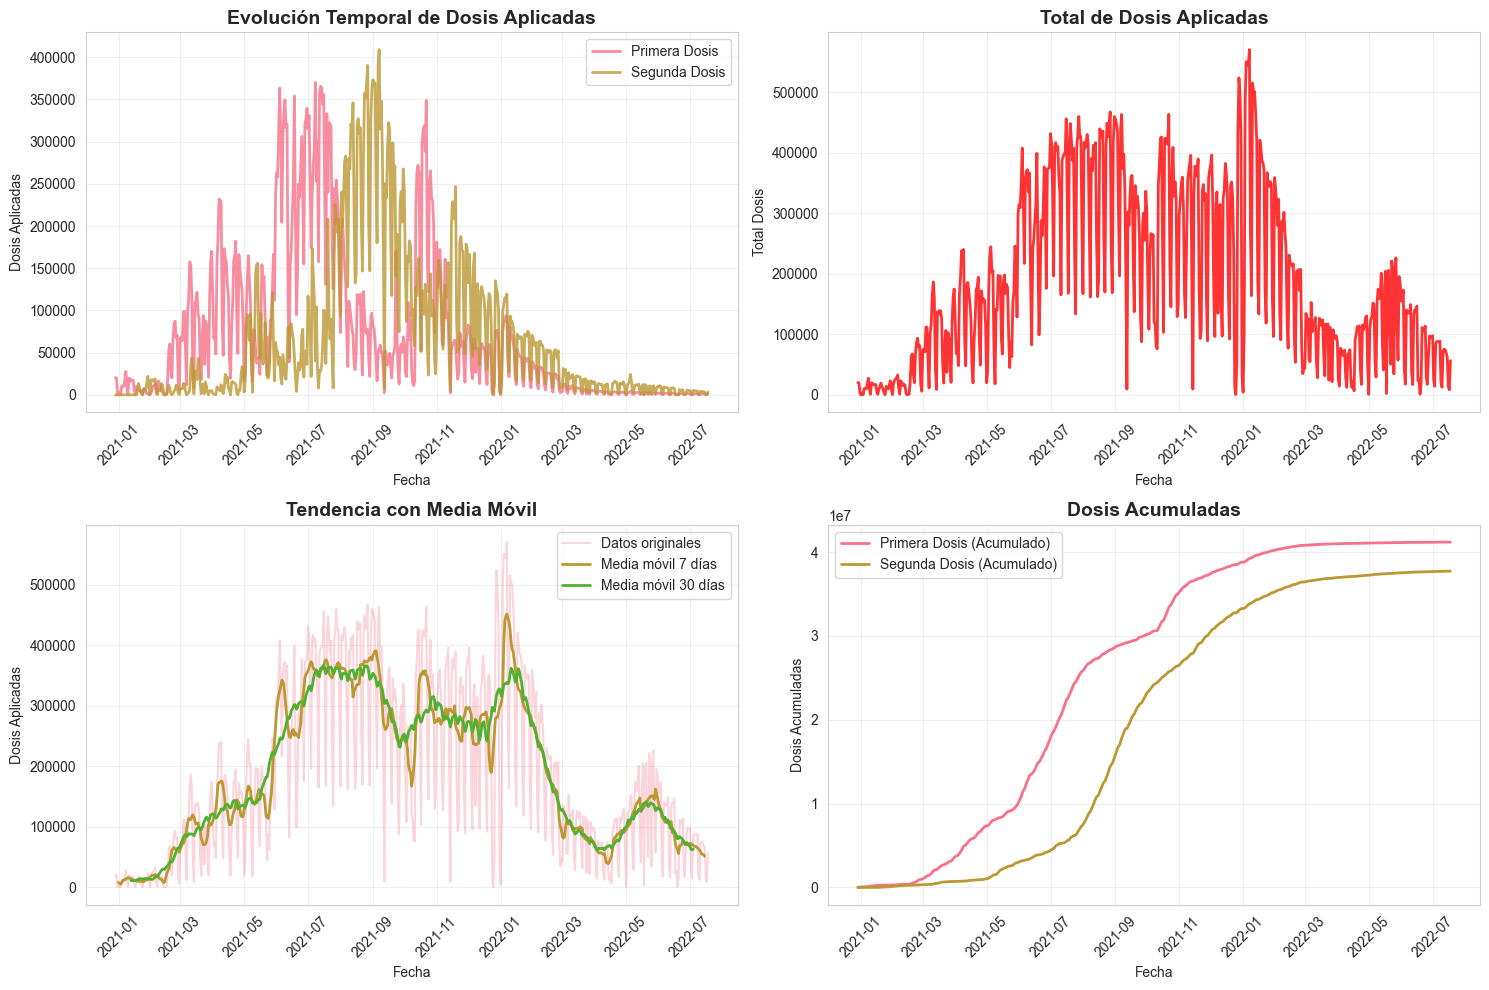

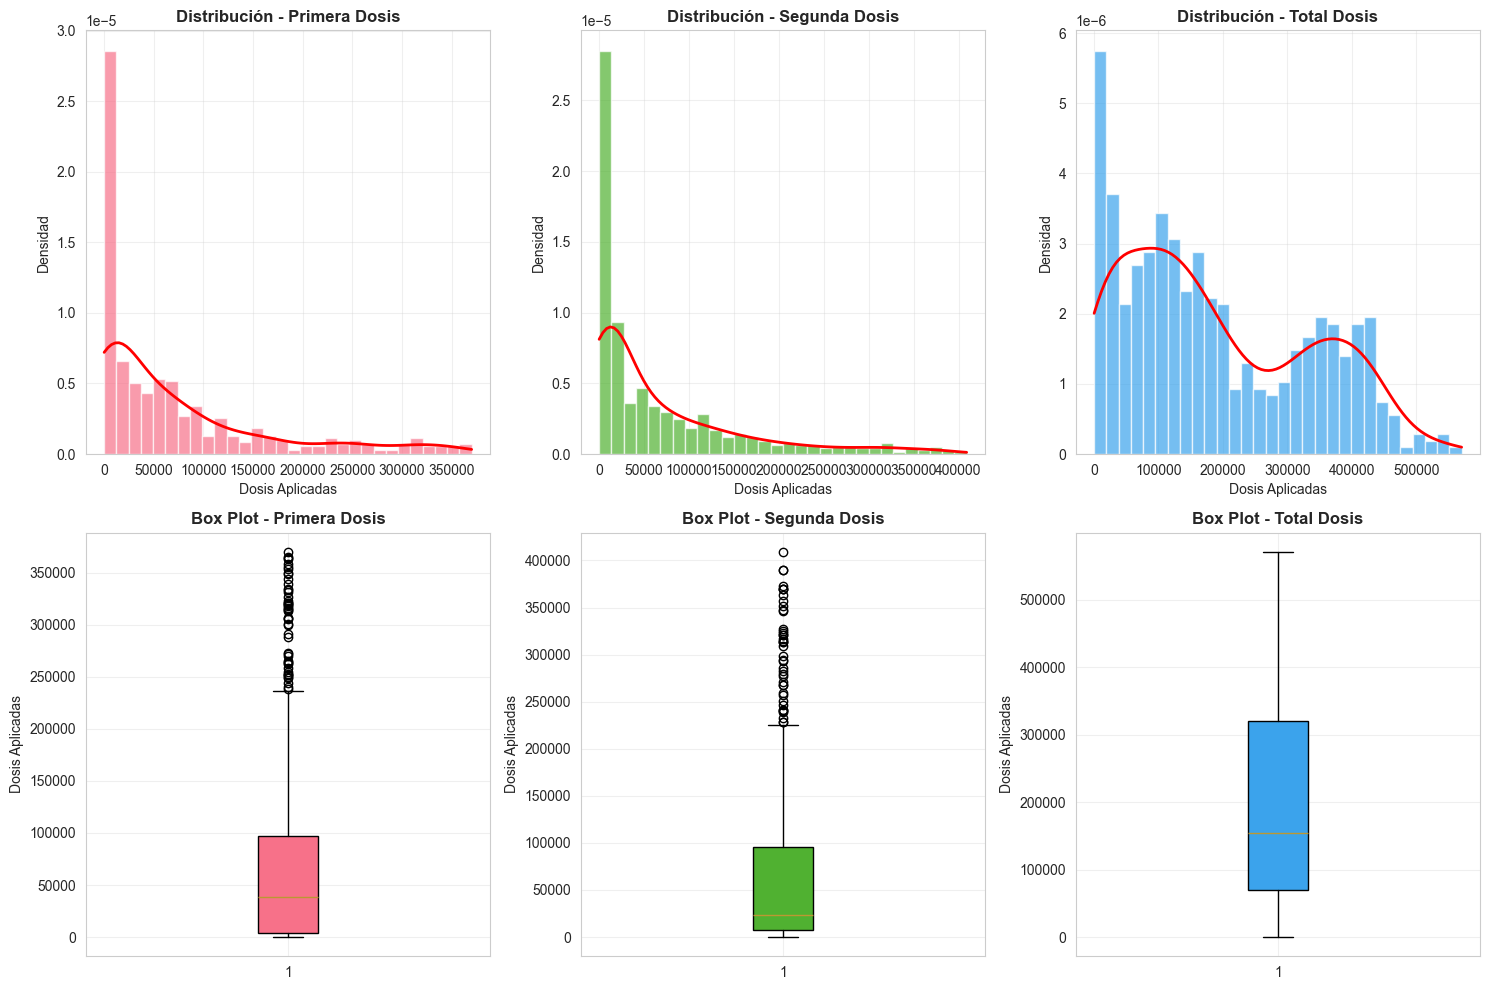

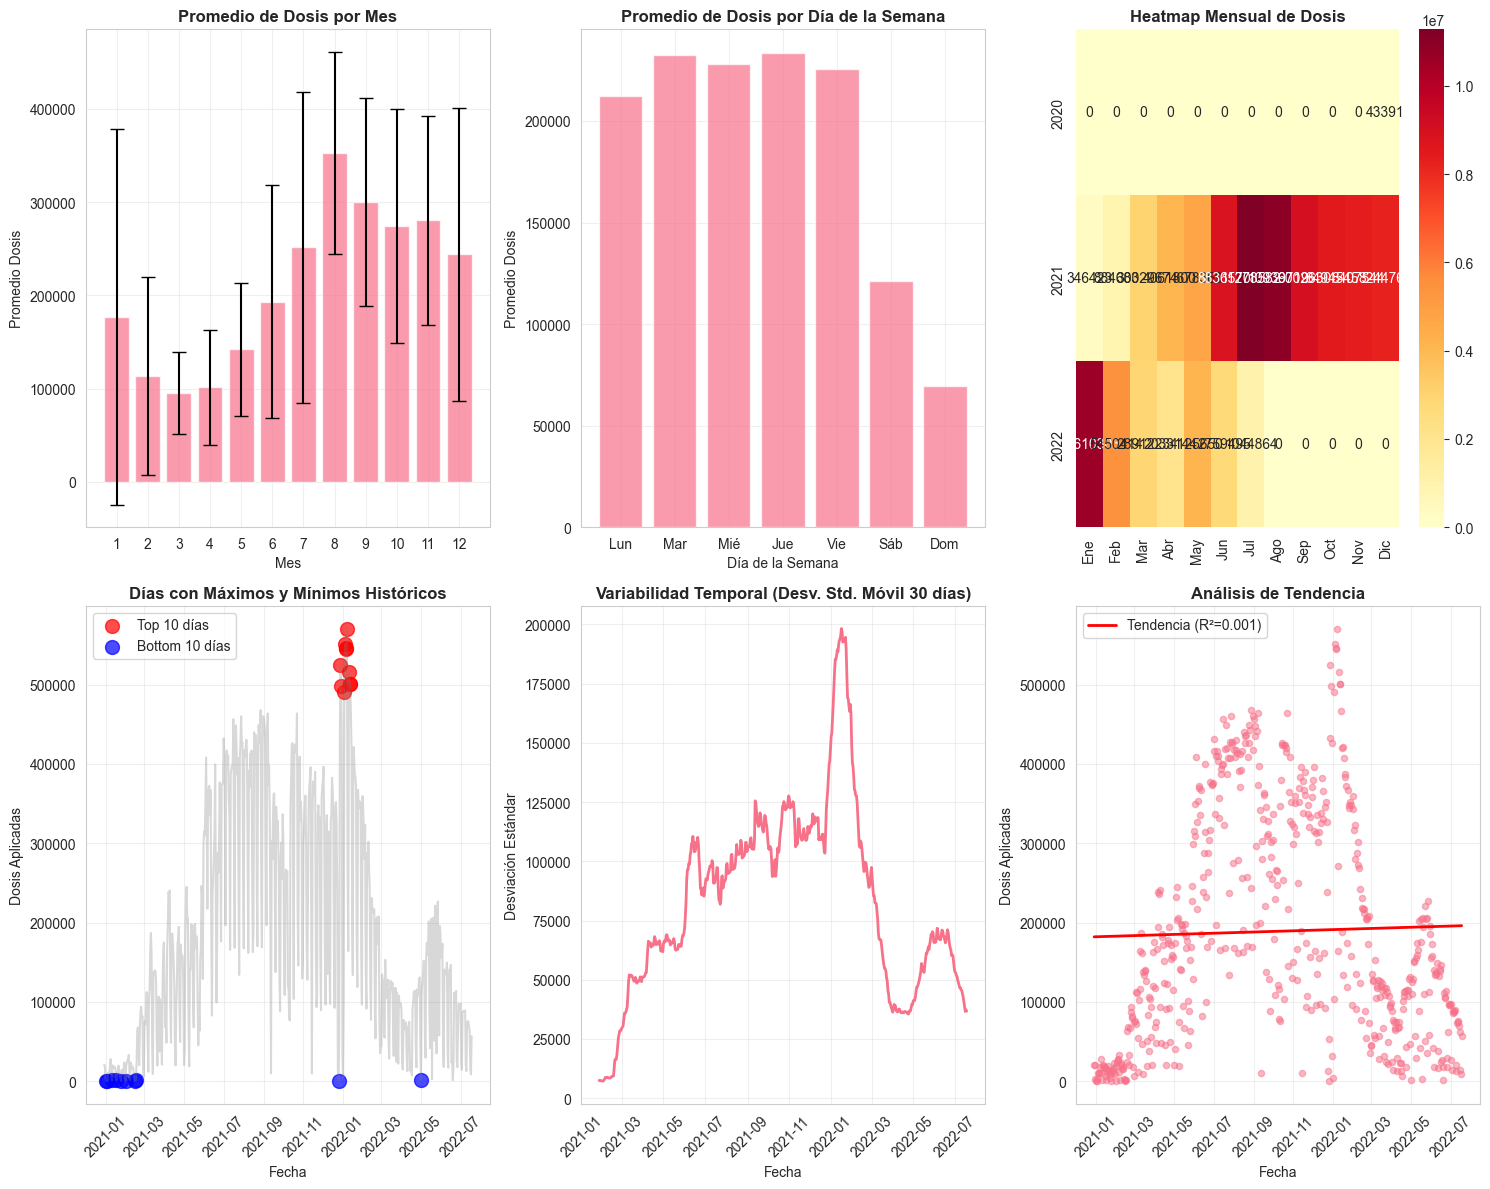


🎲 ANÁLISIS PROBABILÍSTICO
Media de dosis diarias: 188,949
Desviación estándar: 144,387

📊 P(X > media) = 0.411 (41.1%)
📊 P(Q1 ≤ X ≤ Q3) = 0.499 (49.9%)

📊 Probabilidades dentro de desviaciones estándar:
   1σ: 0.584 (58.4%) - Teórico: 68.3%
   2σ: 0.982 (98.2%) - Teórico: 95.4%
   3σ: 1.000 (100.0%) - Teórico: 99.7%

📊 Intervalo de confianza 95% para la media:
   [177,064, 200,834]

🎲 MODELADO BINOMIAL:
n (población estimada): 684,727
p (probabilidad de vacunación): 0.275948


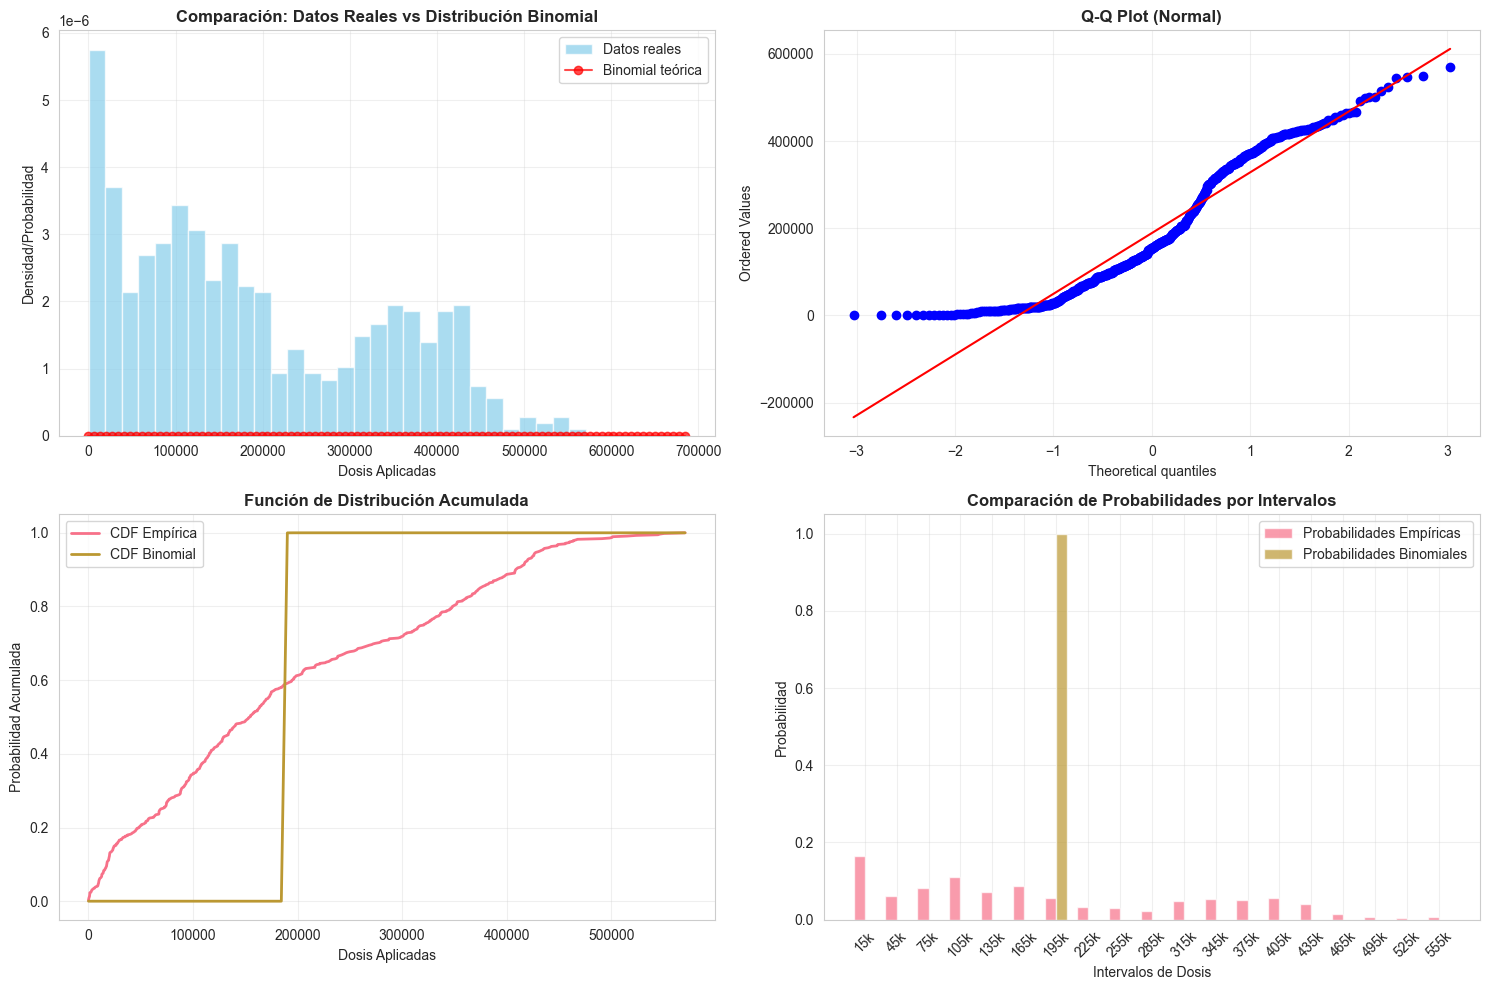


📊 Test de bondad de ajuste (Chi-cuadrado):
   Estadístico: inf
   p-valor: 0.000000
   Ajuste: Pobre (α = 0.05)

🔗 ANÁLISIS DE PROBABILIDAD CONDICIONAL
Umbral 1ra dosis: 38,272
Umbral 2da dosis: 23,430

P(1ra dosis alta) = 0.500
P(2da dosis alta) = 0.500
P(ambas altas) = 0.387
P(2da alta | 1ra alta) = 0.774

Correlación entre 1ra y 2da dosis: 0.230


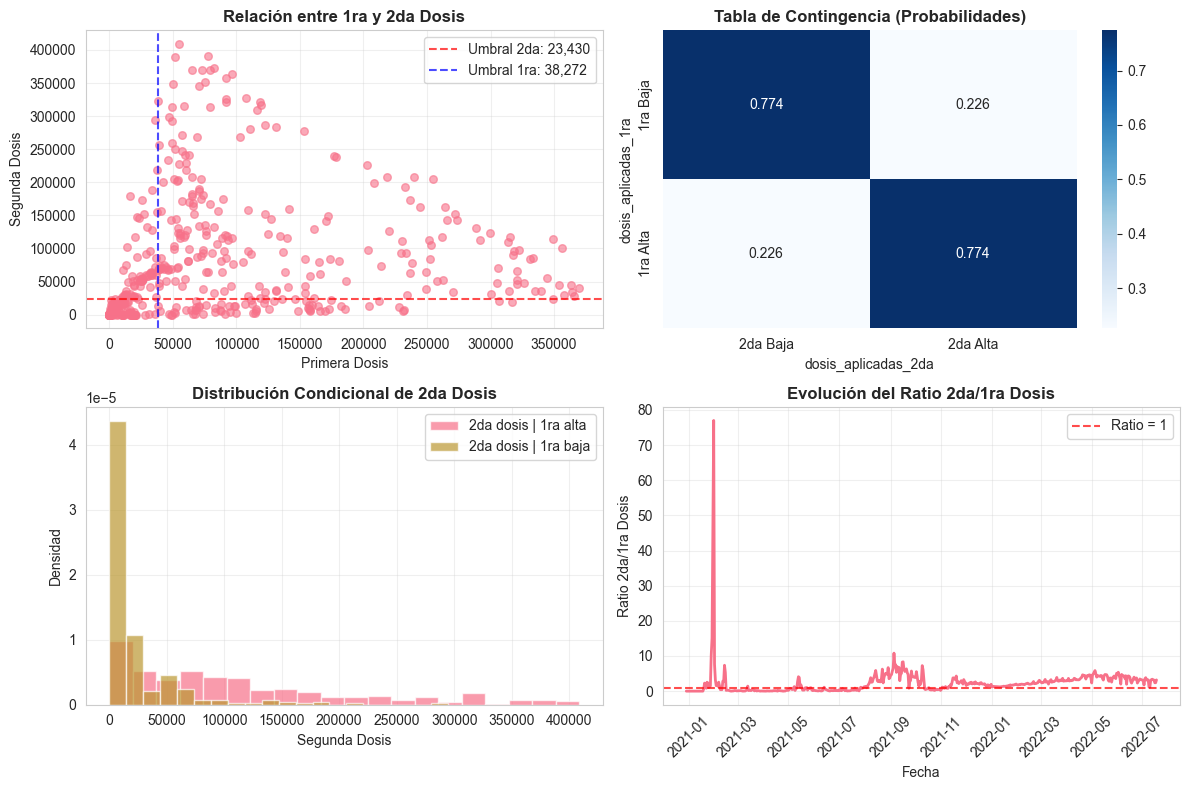


🔮 PROYECCIONES FUTURAS
R² Modelo Lineal: 0.001
R² Modelo Polinomial: 0.485


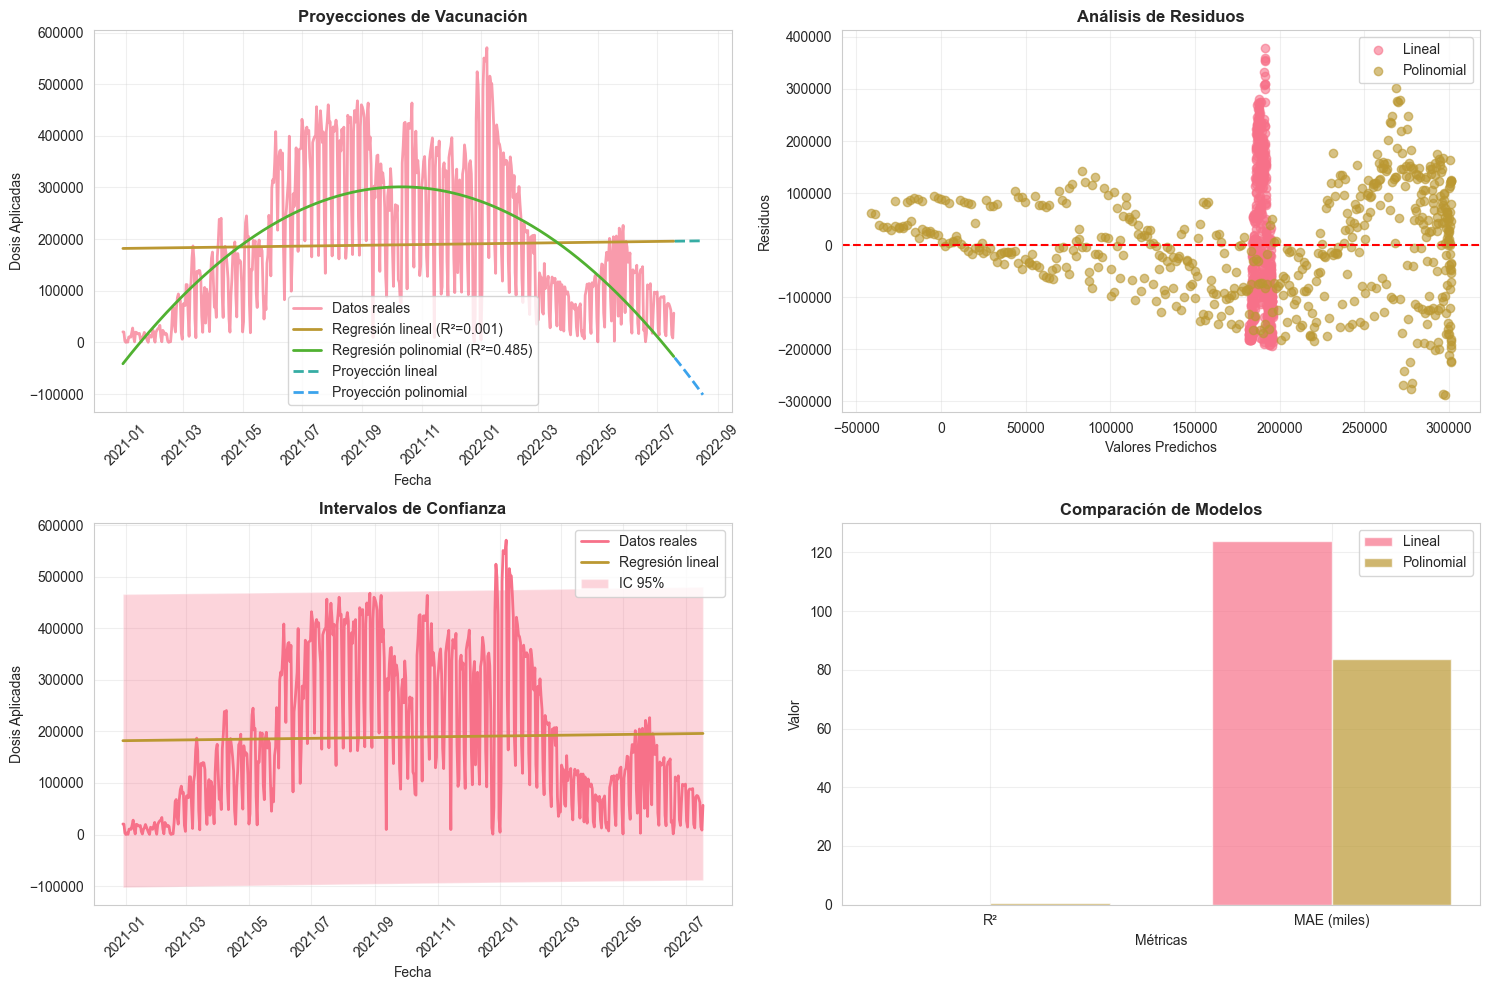


📊 Métricas de evaluación:
   Modelo Lineal - MAE: 123,892
   Modelo Polinomial - MAE: 83,751

📋 INFORME COMPLETO - CONCLUSIONES

🔸 RESUMEN EJECUTIVO
------------------------------

Primera Dosis:
  • Total aplicadas: 41,187,230
  • Promedio diario: 72,641
  • Variabilidad (CV): 125.2%
  • Rango: 8 - 370,022

Segunda Dosis:
  • Total aplicadas: 37,721,821
  • Promedio diario: 66,646
  • Variabilidad (CV): 131.4%
  • Rango: 0 - 408,981

Total Dosis:
  • Total aplicadas: 107,134,084
  • Promedio diario: 188,949
  • Variabilidad (CV): 76.4%
  • Rango: 127 - 570,606

🔸 HALLAZGOS PRINCIPALES
------------------------------
  • Período analizado: 29/12/2020 - 18/07/2022 (566 días)
  • Día con mayor vacunación: 07/01/2022 (570,606 dosis)
  • Día con menor vacunación: 01/01/2021 (127 dosis)
  • Tendencia general: creciente (R² = 0.001)
  • Mejor día de la semana para vacunación: Jueves

🔸 RECOMENDACIONES
------------------------------
  • Mantener estrategias que llevaron a los días de mayor va

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as scipy_stats
from scipy.stats import binom, norm, poisson
import warnings
import os
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.family'] = 'DejaVu Sans'

# Configurar seaborn
sns.set_style("whitegrid")
sns.set_palette("husl")

class AnalisisVacunasCOVIDCompleto:
    
    #Clase para análisis completo de datos de vacunación COVID-19 en Argentina
    #Incluye todos los gráficos y análisis 
    
    
    def __init__(self):
        self.datos_1ra_dosis = None
        self.datos_2da_dosis = None
        self.datos_totales = None
        self.estadisticas_desc = {}
        
        # Rutas de los archivos CAMBIAR ESTAS RUTAS A LAS CORRECTAS EN TU SISTEMA
        self.primera_dosis = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\dato\1_dosis_total_aplicado_a_nivel_nacional_en_valores_diarios.csv"
        self.segunda_dosis = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\dato\2_dosis_total_aplicado_a_nivel_nacional_en_valores_diarios.csv"
        self.total_dosis = r"C:\Users\Admin\Desktop\UNRN\3ero\Mate4\proyecto-mate4\Proyecto_Covid19_Mat\dato\total_de_dosis_aplicadas_a_nivel_nacional_en_valores_diarios_monodosis_1_y_2_dosis.csv"
        
    def cargar_y_limpiar_datos(self):
        
        #Carga y limpia todos los datasets
        
        print("🚀 CARGANDO DATASETS...")
        print("="*50)
        
        try:
            # Cargar primera dosis
            if os.path.exists(self.primera_dosis):
                df_1ra = pd.read_csv(self.primera_dosis, encoding='utf-8')
                df_1ra['fecha'] = pd.to_datetime(df_1ra['indice_tiempo'])
                df_1ra = df_1ra.sort_values('fecha').reset_index(drop=True)
                self.datos_1ra_dosis = df_1ra[['fecha', 'total_1ra_dosis_aplicadas']].copy()
                self.datos_1ra_dosis.rename(columns={'total_1ra_dosis_aplicadas': 'dosis_aplicadas'}, inplace=True)
                print(f"✅ Primera dosis: {len(self.datos_1ra_dosis)} registros")
            
            # Cargar segunda dosis
            if os.path.exists(self.segunda_dosis):
                df_2da = pd.read_csv(self.segunda_dosis, encoding='utf-8')
                df_2da['fecha'] = pd.to_datetime(df_2da['indice_tiempo'])
                df_2da = df_2da.sort_values('fecha').reset_index(drop=True)
                self.datos_2da_dosis = df_2da[['fecha', 'total_2da_dosis_aplicadas']].copy()
                self.datos_2da_dosis.rename(columns={'total_2da_dosis_aplicadas': 'dosis_aplicadas'}, inplace=True)
                print(f"✅ Segunda dosis: {len(self.datos_2da_dosis)} registros")
            
            # Cargar total dosis
            if os.path.exists(self.total_dosis):
                df_total = pd.read_csv(self.total_dosis, encoding='utf-8')
                df_total['fecha'] = pd.to_datetime(df_total['indice_tiempo'])
                df_total = df_total.sort_values('fecha').reset_index(drop=True)
                # Buscar la columna correcta
                col_total = [col for col in df_total.columns if 'dosis' in col.lower() and col != 'indice_tiempo'][0]
                self.datos_totales = df_total[['fecha', col_total]].copy()
                self.datos_totales.rename(columns={col_total: 'dosis_aplicadas'}, inplace=True)
                print(f"✅ Total dosis: {len(self.datos_totales)} registros")
            
            return True
            
        except Exception as e:
            print(f"❌ Error al cargar datos: {e}")
            return False
    
    def estadisticas_descriptivas(self):
        
        #Análisis estadístico descriptivo completo
        
        print("\n" + "="*60)
        print("📊 ESTADÍSTICAS DESCRIPTIVAS")
        print("="*60)
        
        datasets = {
            'Primera Dosis': self.datos_1ra_dosis,
            'Segunda Dosis': self.datos_2da_dosis,
            'Total Dosis': self.datos_totales
        }
        
        resultados = {}
        
        for nombre, df in datasets.items():
            if df is not None and not df.empty:
                dosis = df['dosis_aplicadas']
                
                estadisticas_basicas = {
                    'total': dosis.sum(),
                    'media': dosis.mean(),
                    'mediana': dosis.median(),
                    'moda': dosis.mode().iloc[0] if not dosis.mode().empty else np.nan,
                    'desv_std': dosis.std(),
                    'varianza': dosis.var(),
                    'minimo': dosis.min(),
                    'maximo': dosis.max(),
                    'rango': dosis.max() - dosis.min(),
                    'q1': dosis.quantile(0.25),
                    'q3': dosis.quantile(0.75),
                    'iqr': dosis.quantile(0.75) - dosis.quantile(0.25),
                    'coef_variacion': (dosis.std() / dosis.mean()) * 100,
                    'asimetria': dosis.skew(),
                    'curtosis': dosis.kurtosis()
                }
                
                resultados[nombre] = estadisticas_basicas
                
                print(f"\n🔸 {nombre.upper()}")
                print("-" * 40)
                print(f"Total aplicadas: {estadisticas_basicas['total']:,.0f}")
                print(f"Media: {estadisticas_basicas['media']:,.0f}")
                print(f"Mediana: {estadisticas_basicas['mediana']:,.0f}")
                print(f"Moda: {estadisticas_basicas['moda']:,.0f}")
                print(f"Desviación estándar: {estadisticas_basicas['desv_std']:,.0f}")
                print(f"Varianza: {estadisticas_basicas['varianza']:,.0f}")
                print(f"Mínimo: {estadisticas_basicas['minimo']:,.0f}")
                print(f"Máximo: {estadisticas_basicas['maximo']:,.0f}")
                print(f"Rango: {estadisticas_basicas['rango']:,.0f}")
                print(f"Q1: {estadisticas_basicas['q1']:,.0f}")
                print(f"Q3: {estadisticas_basicas['q3']:,.0f}")
                print(f"IQR: {estadisticas_basicas['iqr']:,.0f}")
                print(f"Coeficiente de variación: {estadisticas_basicas['coef_variacion']:.2f}%")
                print(f"Asimetría: {estadisticas_basicas['asimetria']:.3f}")
                print(f"Curtosis: {estadisticas_basicas['curtosis']:.3f}")
        
        self.estadisticas_desc = resultados
        return resultados
    
    def grafico_series_temporales(self):
        
        #Gráfico 1: Series temporales de todas las dosis
        
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Series individuales ordenadas cronológicamente en el tiempo
        plt.subplot(2, 2, 1)
        if self.datos_1ra_dosis is not None:
            plt.plot(self.datos_1ra_dosis['fecha'], self.datos_1ra_dosis['dosis_aplicadas'], 
                    label='Primera Dosis', linewidth=2, alpha=0.8)
        if self.datos_2da_dosis is not None:
            plt.plot(self.datos_2da_dosis['fecha'], self.datos_2da_dosis['dosis_aplicadas'], 
                    label='Segunda Dosis', linewidth=2, alpha=0.8)
        
        plt.title('Evolución Temporal de Dosis Aplicadas', fontsize=14, fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Dosis Aplicadas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Total de dosis
        plt.subplot(2, 2, 2)
        if self.datos_totales is not None:
            plt.plot(self.datos_totales['fecha'], self.datos_totales['dosis_aplicadas'], 
                    color='red', linewidth=2, alpha=0.8)
            plt.title('Total de Dosis Aplicadas', fontsize=14, fontweight='bold')
            plt.xlabel('Fecha')
            plt.ylabel('Total Dosis')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        
        # Subplot 3: Media móvil (7 días)
        plt.subplot(2, 2, 3)
        if self.datos_totales is not None:
            df_temp = self.datos_totales.copy()
            df_temp['media_movil_7'] = df_temp['dosis_aplicadas'].rolling(window=7, center=True).mean()
            df_temp['media_movil_30'] = df_temp['dosis_aplicadas'].rolling(window=30, center=True).mean()
            
            plt.plot(df_temp['fecha'], df_temp['dosis_aplicadas'], alpha=0.3, label='Datos originales')
            plt.plot(df_temp['fecha'], df_temp['media_movil_7'], linewidth=2, label='Media móvil 7 días')
            plt.plot(df_temp['fecha'], df_temp['media_movil_30'], linewidth=2, label='Media móvil 30 días')
            
            plt.title('Tendencia con Media Móvil', fontsize=14, fontweight='bold')
            plt.xlabel('Fecha')
            plt.ylabel('Dosis Aplicadas')
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        
        # Subplot 4: Comparación acumulada
        plt.subplot(2, 2, 4)
        if self.datos_1ra_dosis is not None and self.datos_2da_dosis is not None:
            cum_1ra = self.datos_1ra_dosis['dosis_aplicadas'].cumsum()
            cum_2da = self.datos_2da_dosis['dosis_aplicadas'].cumsum()
            
            plt.plot(self.datos_1ra_dosis['fecha'], cum_1ra, label='Primera Dosis (Acumulado)', linewidth=2)
            plt.plot(self.datos_2da_dosis['fecha'], cum_2da, label='Segunda Dosis (Acumulado)', linewidth=2)
            
            plt.title('Dosis Acumuladas', fontsize=14, fontweight='bold')
            plt.xlabel('Fecha')
            plt.ylabel('Dosis Acumuladas')
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def grafico_distribucion_histogramas(self):
        
        #Gráfico 2: Histogramas y distribuciones
        
        plt.figure(figsize=(15, 10))
        
        datasets = {
            'Primera Dosis': self.datos_1ra_dosis,
            'Segunda Dosis': self.datos_2da_dosis,
            'Total Dosis': self.datos_totales
        }
        
        for i, (nombre, df) in enumerate(datasets.items(), 1):
            if df is not None and not df.empty:
                plt.subplot(2, 3, i)
                
                # Histograma
                plt.hist(df['dosis_aplicadas'], bins=30, alpha=0.7, density=True, 
                        color=sns.color_palette("husl", 3)[i-1])
                
                # Curva de densidad
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(df['dosis_aplicadas'])
                x_range = np.linspace(df['dosis_aplicadas'].min(), df['dosis_aplicadas'].max(), 100)
                plt.plot(x_range, kde(x_range), linewidth=2, color='red')
                
                plt.title(f'Distribución - {nombre}', fontweight='bold')
                plt.xlabel('Dosis Aplicadas')
                plt.ylabel('Densidad')
                plt.grid(True, alpha=0.3)
        
        # Box plots
        for i, (nombre, df) in enumerate(datasets.items(), 4):
            if df is not None and not df.empty:
                plt.subplot(2, 3, i)
                plt.boxplot(df['dosis_aplicadas'], patch_artist=True,
                           boxprops=dict(facecolor=sns.color_palette("husl", 3)[i-4]))
                plt.title(f'Box Plot - {nombre}', fontweight='bold')
                plt.ylabel('Dosis Aplicadas')
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def grafico_analisis_temporal(self):

        #Gráfico 3: Análisis temporal (ordenadas cronológicamente en el tiempo) detallado 

        if self.datos_totales is None:
            return
        
        df = self.datos_totales.copy()
        df['mes'] = df['fecha'].dt.month
        df['dia_semana'] = df['fecha'].dt.dayofweek
        df['dia_mes'] = df['fecha'].dt.day
        
        plt.figure(figsize=(15, 12))
        
        # Subplot 1: Por mes
        plt.subplot(2, 3, 1)
        monthly_data = df.groupby('mes')['dosis_aplicadas'].agg(['mean', 'std'])
        plt.bar(monthly_data.index, monthly_data['mean'], 
                yerr=monthly_data['std'], capsize=5, alpha=0.7)
        plt.title('Promedio de Dosis por Mes', fontweight='bold')
        plt.xlabel('Mes')
        plt.ylabel('Promedio Dosis')
        plt.xticks(range(1, 13))
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Por día de la semana
        plt.subplot(2, 3, 2)
        dias_semana = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
        weekly_data = df.groupby('dia_semana')['dosis_aplicadas'].mean()
        plt.bar(range(7), weekly_data.values, alpha=0.7)
        plt.title('Promedio de Dosis por Día de la Semana', fontweight='bold')
        plt.xlabel('Día de la Semana')
        plt.ylabel('Promedio Dosis')
        plt.xticks(range(7), dias_semana)
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: Heatmap mensual
        plt.subplot(2, 3, 3)
        df['año_mes'] = df['fecha'].dt.to_period('M')
        monthly_totals = df.groupby('año_mes')['dosis_aplicadas'].sum()
        
        # Crear matriz para heatmap
        años = df['fecha'].dt.year.unique()
        meses = range(1, 13)
        heatmap_data = np.zeros((len(años), 12))
        
        for i, año in enumerate(años):
            for j, mes in enumerate(meses):
                try:
                    periodo = f"{año}-{mes:02d}"
                    if periodo in monthly_totals.index.astype(str):
                        heatmap_data[i, j] = monthly_totals[periodo]
                except:
                    pass
        
        sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd',
                   xticklabels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                              'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
                   yticklabels=años)
        plt.title('Heatmap Mensual de Dosis', fontweight='bold')
        
        # Subplot 4: Máximos y mínimos históricos
        plt.subplot(2, 3, 4)
        # Encontrar los 10 días con más y menos dosis
        top_10 = df.nlargest(10, 'dosis_aplicadas')
        bottom_10 = df.nsmallest(10, 'dosis_aplicadas')
        
        plt.scatter(top_10['fecha'], top_10['dosis_aplicadas'], 
                   color='red', s=100, alpha=0.7, label='Top 10 días')
        plt.scatter(bottom_10['fecha'], bottom_10['dosis_aplicadas'], 
                   color='blue', s=100, alpha=0.7, label='Bottom 10 días')
        plt.plot(df['fecha'], df['dosis_aplicadas'], alpha=0.3, color='gray')
        
        plt.title('Días con Máximos y Mínimos Históricos', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Dosis Aplicadas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Subplot 5: Variabilidad temporal
        plt.subplot(2, 3, 5)
        df['rolling_std'] = df['dosis_aplicadas'].rolling(window=30).std()
        plt.plot(df['fecha'], df['rolling_std'], linewidth=2)
        plt.title('Variabilidad Temporal (Desv. Std. Móvil 30 días)', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Desviación Estándar')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Subplot 6: Tendencia y regresión
        plt.subplot(2, 3, 6)
        x = np.arange(len(df))
        y = df['dosis_aplicadas'].values
        
        # Regresión lineal
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
        line = slope * x + intercept
        
        plt.scatter(df['fecha'], df['dosis_aplicadas'], alpha=0.5, s=20)
        plt.plot(df['fecha'], line, color='red', linewidth=2, 
                label=f'Tendencia (R²={r_value**2:.3f})')
        
        plt.title('Análisis de Tendencia', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Dosis Aplicadas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analisis_probabilistico(self):
        
        #Análisis probabilístico completo
        
        print("\n" + "="*60)
        print("🎲 ANÁLISIS PROBABILÍSTICO")
        print("="*60)
        
        if self.datos_totales is None:
            print("❌ No hay datos disponibles para análisis probabilístico")
            return
        
        dosis = self.datos_totales['dosis_aplicadas']
        media = dosis.mean()
        std = dosis.std()
        
        print(f"Media de dosis diarias: {media:,.0f}")
        print(f"Desviación estándar: {std:,.0f}")
        
        # 1. Probabilidad de aplicar más dosis que la media
        prob_mayor_media = (dosis > media).mean()
        print(f"\n📊 P(X > media) = {prob_mayor_media:.3f} ({prob_mayor_media*100:.1f}%)")
        
        # 2. Probabilidad de estar en diferentes intervalos
        q1, q3 = dosis.quantile([0.25, 0.75])
        prob_q1_q3 = ((dosis >= q1) & (dosis <= q3)).mean()
        print(f"📊 P(Q1 ≤ X ≤ Q3) = {prob_q1_q3:.3f} ({prob_q1_q3*100:.1f}%)")
        
        # 3. Probabilidad usando distribución normal
        # Normalizar los datos
        z_scores = (dosis - media) / std
        
        # Probabilidad de estar dentro de 1, 2, 3 desviaciones estándar
        prob_1std = ((z_scores >= -1) & (z_scores <= 1)).mean()
        prob_2std = ((z_scores >= -2) & (z_scores <= 2)).mean()
        prob_3std = ((z_scores >= -3) & (z_scores <= 3)).mean()
        
        print(f"\n📊 Probabilidades dentro de desviaciones estándar:")
        print(f"   1σ: {prob_1std:.3f} ({prob_1std*100:.1f}%) - Teórico: 68.3%")
        print(f"   2σ: {prob_2std:.3f} ({prob_2std*100:.1f}%) - Teórico: 95.4%")
        print(f"   3σ: {prob_3std:.3f} ({prob_3std*100:.1f}%) - Teórico: 99.7%")
        
        # 4. Intervalos de confianza
        ic_95_inf = media - 1.96 * (std / np.sqrt(len(dosis)))
        ic_95_sup = media + 1.96 * (std / np.sqrt(len(dosis)))
        
        print(f"\n📊 Intervalo de confianza 95% para la media:")
        print(f"   [{ic_95_inf:,.0f}, {ic_95_sup:,.0f}]")
        
        return {
            'prob_mayor_media': prob_mayor_media,
            'prob_q1_q3': prob_q1_q3,
            'prob_1std': prob_1std,
            'prob_2std': prob_2std,
            'prob_3std': prob_3std,
            'ic_95': (ic_95_inf, ic_95_sup)
        }
    
    def grafico_distribucion_binomial(self):
        
        #Gráfico 4: Modelado con distribución binomial
        
        if self.datos_totales is None:
            return
        
        plt.figure(figsize=(15, 10))
        
        dosis = self.datos_totales['dosis_aplicadas']
        
        # Parámetros para la binomial
        # Asumimos una población objetivo diaria estimada
        n_poblacion = int(dosis.max() * 1.2)  # Población objetivo estimada
        p_exito = dosis.mean() / n_poblacion   # Probabilidad de éxito
        
        print(f"\n🎲 MODELADO BINOMIAL:")
        print(f"n (población estimada): {n_poblacion:,}")
        print(f"p (probabilidad de vacunación): {p_exito:.6f}")
        
        # Subplot 1: Comparación histograma real vs binomial teórica
        plt.subplot(2, 2, 1)
        
        # Histograma de datos reales
        plt.hist(dosis, bins=30, alpha=0.7, density=True, label='Datos reales', color='skyblue')
        
        # Distribución binomial teórica
        x_binom = np.arange(0, n_poblacion, n_poblacion//100)
        y_binom = binom.pmf(x_binom, n_poblacion, p_exito)
        plt.plot(x_binom, y_binom, 'ro-', alpha=0.7, label='Binomial teórica')
        
        plt.title('Comparación: Datos Reales vs Distribución Binomial', fontweight='bold')
        plt.xlabel('Dosis Aplicadas')
        plt.ylabel('Densidad/Probabilidad')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Q-Q plot para evaluar ajuste
        plt.subplot(2, 2, 2)
        
        # Q-Q plot
        scipy_stats.probplot(dosis, dist=scipy_stats.norm, plot=plt)
        plt.title('Q-Q Plot (Normal)', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: Función de distribución acumulada
        plt.subplot(2, 2, 3)
        
        # CDF empírica
        x_sorted = np.sort(dosis)
        y_empirica = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
        plt.plot(x_sorted, y_empirica, label='CDF Empírica', linewidth=2)
        
        # CDF binomial
        x_teorica = np.linspace(dosis.min(), dosis.max(), 100)
        y_teorica = binom.cdf(x_teorica, n_poblacion, p_exito)
        plt.plot(x_teorica, y_teorica, label='CDF Binomial', linewidth=2)
        
        plt.title('Función de Distribución Acumulada', fontweight='bold')
        plt.xlabel('Dosis Aplicadas')
        plt.ylabel('Probabilidad Acumulada')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 4: Gráfico de barras de probabilidades
        plt.subplot(2, 2, 4)
        
        # Crear intervalos para el gráfico de barras
        bins = np.linspace(dosis.min(), dosis.max(), 20)
        hist_counts, bin_edges = np.histogram(dosis, bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Normalizar para obtener probabilidades
        probabilidades_empiricas = hist_counts / len(dosis)
        
        # Probabilidades teóricas binomiales para cada intervalo
        probabilidades_teoricas = []
        for i in range(len(bin_edges)-1):
            prob = binom.cdf(bin_edges[i+1], n_poblacion, p_exito) - binom.cdf(bin_edges[i], n_poblacion, p_exito)
            probabilidades_teoricas.append(prob)
        
        x_pos = np.arange(len(bin_centers))
        width = 0.35
        
        plt.bar(x_pos - width/2, probabilidades_empiricas, width, 
                label='Probabilidades Empíricas', alpha=0.7)
        plt.bar(x_pos + width/2, probabilidades_teoricas, width, 
                label='Probabilidades Binomiales', alpha=0.7)
        
        plt.title('Comparación de Probabilidades por Intervalos', fontweight='bold')
        plt.xlabel('Intervalos de Dosis')
        plt.ylabel('Probabilidad')
        plt.legend()
        plt.xticks(x_pos, [f'{int(x/1000)}k' for x in bin_centers], rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Test de bondad de ajuste
        from scipy.stats import chisquare
        chi2_stat, p_value = chisquare(hist_counts, 
                                      [prob * len(dosis) for prob in probabilidades_teoricas])
        
        print(f"\n📊 Test de bondad de ajuste (Chi-cuadrado):")
        print(f"   Estadístico: {chi2_stat:.3f}")
        print(f"   p-valor: {p_value:.6f}")
        print(f"   Ajuste: {'Bueno' if p_value > 0.05 else 'Pobre'} (α = 0.05)")
    
    def probabilidad_condicional(self):
        
        #Análisis de probabilidad condicional
        
        print("\n" + "="*60)
        print("🔗 ANÁLISIS DE PROBABILIDAD CONDICIONAL")
        print("="*60)
        
        if self.datos_1ra_dosis is None or self.datos_2da_dosis is None:
            print("❌ Se necesitan datos de primera y segunda dosis")
            return
        
        # Alinear fechas para comparación
        df_merged = pd.merge(self.datos_1ra_dosis, self.datos_2da_dosis, 
                           on='fecha', suffixes=('_1ra', '_2da'), how='inner')
        
        # Calcular probabilidades condicionales
        # P(2da dosis | 1ra dosis aplicada)
        
        # Definir umbrales
        umbral_1ra = df_merged['dosis_aplicadas_1ra'].median()
        umbral_2da = df_merged['dosis_aplicadas_2da'].median()
        
        # Eventos
        evento_1ra_alta = df_merged['dosis_aplicadas_1ra'] > umbral_1ra
        evento_2da_alta = df_merged['dosis_aplicadas_2da'] > umbral_2da
        
        # P(A ∩ B)
        prob_ambas_altas = (evento_1ra_alta & evento_2da_alta).mean()
        
        # P(A)
        prob_1ra_alta = evento_1ra_alta.mean()
        
        # P(B|A) = P(A ∩ B) / P(A)
        prob_2da_dado_1ra = prob_ambas_altas / prob_1ra_alta if prob_1ra_alta > 0 else 0
        
        print(f"Umbral 1ra dosis: {umbral_1ra:,.0f}")
        print(f"Umbral 2da dosis: {umbral_2da:,.0f}")
        print(f"\nP(1ra dosis alta) = {prob_1ra_alta:.3f}")
        print(f"P(2da dosis alta) = {evento_2da_alta.mean():.3f}")
        print(f"P(ambas altas) = {prob_ambas_altas:.3f}")
        print(f"P(2da alta | 1ra alta) = {prob_2da_dado_1ra:.3f}")
        
        # Correlación entre primera y segunda dosis
        correlacion = df_merged['dosis_aplicadas_1ra'].corr(df_merged['dosis_aplicadas_2da'])
        print(f"\nCorrelación entre 1ra y 2da dosis: {correlacion:.3f}")
        
        # Gráfico de probabilidad condicional
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.scatter(df_merged['dosis_aplicadas_1ra'], df_merged['dosis_aplicadas_2da'], 
                   alpha=0.6, s=30)
        plt.axhline(y=umbral_2da, color='red', linestyle='--', alpha=0.7, label=f'Umbral 2da: {umbral_2da:,.0f}')
        plt.axvline(x=umbral_1ra, color='blue', linestyle='--', alpha=0.7, label=f'Umbral 1ra: {umbral_1ra:,.0f}')
        plt.xlabel('Primera Dosis')
        plt.ylabel('Segunda Dosis')
        plt.title('Relación entre 1ra y 2da Dosis', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Tabla de contingencia
        plt.subplot(2, 2, 2)
        contingencia = pd.crosstab(evento_1ra_alta, evento_2da_alta, normalize='index')
        sns.heatmap(contingencia, annot=True, fmt='.3f', cmap='Blues',
                   xticklabels=['2da Baja', '2da Alta'],
                   yticklabels=['1ra Baja', '1ra Alta'])
        plt.title('Tabla de Contingencia (Probabilidades)', fontweight='bold')
        
        plt.subplot(2, 2, 3)
        # Distribución condicional
        df_1ra_alta = df_merged[evento_1ra_alta]['dosis_aplicadas_2da']
        df_1ra_baja = df_merged[~evento_1ra_alta]['dosis_aplicadas_2da']
        
        plt.hist(df_1ra_alta, bins=20, alpha=0.7, label='2da dosis | 1ra alta', density=True)
        plt.hist(df_1ra_baja, bins=20, alpha=0.7, label='2da dosis | 1ra baja', density=True)
        plt.xlabel('Segunda Dosis')
        plt.ylabel('Densidad')
        plt.title('Distribución Condicional de 2da Dosis', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        # Evolución temporal de la relación
        df_merged['ratio_2da_1ra'] = df_merged['dosis_aplicadas_2da'] / df_merged['dosis_aplicadas_1ra']
        df_merged['ratio_2da_1ra'] = df_merged['ratio_2da_1ra'].replace([np.inf, -np.inf], np.nan)
        
        plt.plot(df_merged['fecha'], df_merged['ratio_2da_1ra'], linewidth=2)
        plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Ratio = 1')
        plt.xlabel('Fecha')
        plt.ylabel('Ratio 2da/1ra Dosis')
        plt.title('Evolución del Ratio 2da/1ra Dosis', fontweight='bold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'prob_2da_dado_1ra': prob_2da_dado_1ra,
            'correlacion': correlacion,
            'prob_1ra_alta': prob_1ra_alta,
            'prob_2da_alta': evento_2da_alta.mean(),
            'prob_ambas_altas': prob_ambas_altas
        }
    
    def proyecciones_futuras(self):
        
        #Proyecciones y estimaciones futuras
        
        print("\n" + "="*60)
        print("🔮 PROYECCIONES FUTURAS")
        print("="*60)
        
        if self.datos_totales is None:
            return
        
        df = self.datos_totales.copy()
        
        # Preparar datos para regresión
        df['dias'] = (df['fecha'] - df['fecha'].min()).dt.days
        X = df['dias'].values.reshape(-1, 1)
        y = df['dosis_aplicadas'].values
        
        # Regresión lineal simple usando scipy
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(df['dias'], y)
        y_pred_lineal = slope * df['dias'] + intercept
        r2_lineal = r_value**2
        
        # Modelo polinomial simple (grado 2)
        # Ajuste polinomial usando numpy
        coef_poly = np.polyfit(df['dias'], y, 2)
        y_pred_poly = np.polyval(coef_poly, df['dias'])
        
        # Calcular R² para el modelo polinomial
        ss_res_poly = np.sum((y - y_pred_poly) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2_poly = 1 - (ss_res_poly / ss_tot)
        
        print(f"R² Modelo Lineal: {r2_lineal:.3f}")
        print(f"R² Modelo Polinomial: {r2_poly:.3f}")
        
        # Proyección a futuro (30 días)
        dias_futuros = np.arange(df['dias'].max() + 1, df['dias'].max() + 31)
        fechas_futuras = [df['fecha'].max() + timedelta(days=i) for i in range(1, 31)]
        
        # Predicciones
        pred_lineal_futuro = slope * dias_futuros + intercept
        pred_poly_futuro = np.polyval(coef_poly, dias_futuros)
        
        # Gráfico de proyecciones
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(df['fecha'], y, label='Datos reales', linewidth=2, alpha=0.7)
        plt.plot(df['fecha'], y_pred_lineal, label=f'Regresión lineal (R²={r2_lineal:.3f})', linewidth=2)
        plt.plot(df['fecha'], y_pred_poly, label=f'Regresión polinomial (R²={r2_poly:.3f})', linewidth=2)
        plt.plot(fechas_futuras, pred_lineal_futuro, '--', label='Proyección lineal', linewidth=2)
        plt.plot(fechas_futuras, pred_poly_futuro, '--', label='Proyección polinomial', linewidth=2)
        
        plt.title('Proyecciones de Vacunación', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Dosis Aplicadas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Análisis de residuos
        plt.subplot(2, 2, 2)
        residuos_lineal = y - y_pred_lineal
        residuos_poly = y - y_pred_poly
        
        plt.scatter(y_pred_lineal, residuos_lineal, alpha=0.6, label='Lineal')
        plt.scatter(y_pred_poly, residuos_poly, alpha=0.6, label='Polinomial')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Valores Predichos')
        plt.ylabel('Residuos')
        plt.title('Análisis de Residuos', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Intervalos de confianza
        plt.subplot(2, 2, 3)
        
        # Calcular intervalos de confianza para la regresión lineal
        n = len(y)
        mse = np.mean(residuos_lineal**2)
        t_val = scipy_stats.t.ppf(0.975, n-2)  # 95% de confianza
        
        # Error estándar de la predicción
        X_mean = np.mean(df['dias'])
        se_pred = np.sqrt(mse * (1 + 1/n + (df['dias'] - X_mean)**2 / np.sum((df['dias'] - X_mean)**2)))
        
        ic_inferior = y_pred_lineal - t_val * se_pred
        ic_superior = y_pred_lineal + t_val * se_pred
        
        plt.plot(df['fecha'], y, label='Datos reales', linewidth=2)
        plt.plot(df['fecha'], y_pred_lineal, label='Regresión lineal', linewidth=2)
        plt.fill_between(df['fecha'], ic_inferior, ic_superior, alpha=0.3, label='IC 95%')
        
        plt.title('Intervalos de Confianza', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Dosis Aplicadas')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Métricas de evaluación
        plt.subplot(2, 2, 4)
        
        mae_lineal = np.mean(np.abs(residuos_lineal))
        mae_poly = np.mean(np.abs(residuos_poly))
        
        metricas = ['R²', 'MAE (miles)']
        lineal_scores = [r2_lineal, mae_lineal/1000]  # MAE en miles
        poly_scores = [r2_poly, mae_poly/1000]
        
        x_pos = np.arange(len(metricas))
        width = 0.35
        
        plt.bar(x_pos - width/2, lineal_scores, width, label='Lineal', alpha=0.7)
        plt.bar(x_pos + width/2, poly_scores, width, label='Polinomial', alpha=0.7)
        
        plt.xlabel('Métricas')
        plt.ylabel('Valor')
        plt.title('Comparación de Modelos', fontweight='bold')
        plt.xticks(x_pos, metricas)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Métricas de evaluación:")
        print(f"   Modelo Lineal - MAE: {mae_lineal:,.0f}")
        print(f"   Modelo Polinomial - MAE: {mae_poly:,.0f}")
        
        return {
            'r2_lineal': r2_lineal,
            'r2_poly': r2_poly,
            'proyeccion_30_dias': {
                'fechas': fechas_futuras,
                'lineal': pred_lineal_futuro,
                'polinomial': pred_poly_futuro
            }
        }
    
    def generar_informe_completo(self):
        
        #Genera el informe completo con todas las conclusiones
        
        print("\n" + "="*60)
        print("📋 INFORME COMPLETO - CONCLUSIONES")
        print("="*60)
        
        # Resumen ejecutivo
        if self.estadisticas_desc:
            print("\n🔸 RESUMEN EJECUTIVO")
            print("-" * 30)
            
            for nombre, estadisticas_basicas in self.estadisticas_desc.items():
                print(f"\n{nombre}:")
                print(f"  • Total aplicadas: {estadisticas_basicas['total']:,.0f}")
                print(f"  • Promedio diario: {estadisticas_basicas['media']:,.0f}")
                print(f"  • Variabilidad (CV): {estadisticas_basicas['coef_variacion']:.1f}%")
                print(f"  • Rango: {estadisticas_basicas['minimo']:,.0f} - {estadisticas_basicas['maximo']:,.0f}")
        
        # Hallazgos principales
        print(f"\n🔸 HALLAZGOS PRINCIPALES")
        print("-" * 30)
        
        if self.datos_totales is not None:
            df = self.datos_totales
            
            # Período de análisis
            periodo_inicio = df['fecha'].min().strftime('%d/%m/%Y')
            periodo_fin = df['fecha'].max().strftime('%d/%m/%Y')
            dias_total = (df['fecha'].max() - df['fecha'].min()).days
            
            print(f"  • Período analizado: {periodo_inicio} - {periodo_fin} ({dias_total} días)")
            
            # Picos y valles
            max_dosis = df['dosis_aplicadas'].max()
            fecha_max = df.loc[df['dosis_aplicadas'].idxmax(), 'fecha'].strftime('%d/%m/%Y')
            min_dosis = df['dosis_aplicadas'].min()
            fecha_min = df.loc[df['dosis_aplicadas'].idxmin(), 'fecha'].strftime('%d/%m/%Y')
            
            print(f"  • Día con mayor vacunación: {fecha_max} ({max_dosis:,.0f} dosis)")
            print(f"  • Día con menor vacunación: {fecha_min} ({min_dosis:,.0f} dosis)")
            
            # Tendencia general
            x = np.arange(len(df))
            y = df['dosis_aplicadas'].values
            slope, _, r_value, _, _ = scipy_stats.linregress(x, y)
            tendencia = "creciente" if slope > 0 else "decreciente"
            
            print(f"  • Tendencia general: {tendencia} (R² = {r_value**2:.3f})")
            
            # Estacionalidad
            df_temp = df.copy()
            df_temp['dia_semana'] = df_temp['fecha'].dt.dayofweek
            mejor_dia = df_temp.groupby('dia_semana')['dosis_aplicadas'].mean().idxmax()
            dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
            
            print(f"  • Mejor día de la semana para vacunación: {dias_semana[mejor_dia]}")
        
        # Recomendaciones
        print(f"\n🔸 RECOMENDACIONES")
        print("-" * 30)
        print("  • Mantener estrategias que llevaron a los días de mayor vacunación")
        print("  • Analizar factores que causaron días de baja vacunación")
        print("  • Considerar patrones semanales para optimizar recursos")
        print("  • Implementar sistemas de alerta temprana para detectar caídas")
        print("  • Desarrollar campañas específicas basadas en análisis temporal")
        
        # Limitaciones del estudio
        print(f"\n🔸 LIMITACIONES DEL ESTUDIO")
        print("-" * 30)
        print("  • Datos agregados a nivel nacional (sin segmentación provincial)")
        print("  • No incluye información demográfica (edad, género)")
        print("  • No considera factores externos (políticas, eventos)")
        print("  • Período limitado de análisis")
        print("  • No incluye datos de efectividad o reacciones adversas")
        
        print(f"\n🎉 ANÁLISIS COMPLETADO")
        print("="*60)
    
    def ejecutar_analisis_completo(self):
        
        #Ejecuta todo el análisis completo
        
        print("🚀 INICIANDO ANÁLISIS COMPLETO COVID-19")
        print("="*60)
        
        # 1. Cargar datos
        if not self.cargar_y_limpiar_datos():
            print("❌ Error al cargar datos")
            return
        
        # 2. Estadísticas descriptivas
        self.estadisticas_descriptivas()
        
        # 3. Gráficos principales
        print("\n📊 Generando gráficos...")
        self.grafico_series_temporales()
        self.grafico_distribucion_histogramas()
        self.grafico_analisis_temporal()
        
        # 4. Análisis probabilístico
        prob_results = self.analisis_probabilistico()
        
        # 5. Distribución binomial
        self.grafico_distribucion_binomial()
        
        # 6. Probabilidad condicional
        cond_results = self.probabilidad_condicional()
        
        # 7. Proyecciones
        proj_results = self.proyecciones_futuras()
        
        # 8. Informe final
        self.generar_informe_completo()
        
        return {
            'estadisticas': self.estadisticas_desc,
            'probabilidades': prob_results,
            'condicionales': cond_results,
            'proyecciones': proj_results
        }


# Función principal
def main():
    
    #Main principal -  ejecuta el análisis completo
    
    # Crear analizador y ejecutar
    analizador = AnalisisVacunasCOVIDCompleto()
    resultados = analizador.ejecutar_analisis_completo()
    
    return resultados


if __name__ == "__main__":
    resultados = main()